# Predicción del Rendimiento de Jugadores de Fútbol Utilizando la Base de Datos de FIFA y Redes Neuronales Recurrentes

### Juan Sebastian Rodríguez Salazar y Alejandro Rafael Vega Saavedra

A continuación, se importan bibliotecas esenciales, incluyendo pandas para manejo de datos, sklearn para procesamiento y reducción de dimensiones, y tensorflow.keras para construir y entrenar modelos de redes neuronales recurrentes. Luego, se carga un archivo CSV que contiene datos los datos que se van a procesar.

In [ ]:
# Importa las bibliotecas necesarias
import pandas as pd
from google.colab import files
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Masking, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# Cargar archivo CSV desde tu computadora
df =pd.read_csv("/content/cleaned_combined_fifa_data_filtered.csv")



# Ver las primeras filas del DataFrame
df.head()


<ipython-input-1-72fe1ef8ac1c>:18: DtypeWarning: Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df =pd.read_csv("/content/cleaned_combined_fifa_data_filtered.csv")


id          Fullname  current_rating  potential_rating  height weight  \
0    3721      Nenad Dzodic              68                80     187     81   
1  146781        AranzÃ¡bal              80                85     186     78   
2   49888    Anders Jonsson              45                56     186     83   
3   45452  Jonathan Bourdon              63                80     180     75   
4  150655  Gilles Yapi Yapo              79                84     171     63   

  preferred_foot  birth_date preferred_positions        work_rate  ...  \
0          Right  1977-01-04                  CB    Medium/Medium  ...   
1           Left  1973-03-15         LWB-LWM-LAM    Medium/Medium  ...   
2          Right  1975-11-05                  GK    Medium/Medium  ...   
3          Right  1981-09-03                  GK    Medium/Medium  ...   
4          Right  1982-01-30              RAM-RM  Medium / Medium  ...   

     agility    jumping      curve     fk_acc  penalties    volleys  \
0  64.061838  58.796288  45.727156  46.045577   46.24457  29.337127   
1  64.061838  58.796288  45.727156  46.045577   46.24457  29.337127   
2  64.061838  58.796288  45.727156  46.045577   46.24457  29.337127   
3  64.061838  58.796288  45.727156  46.045577   46.24457  29.337127   
4  64.061838  58.796288  45.727156  46.045577   46.24457  29.337127   

   gk_handling  gk_kicking  gk_reflexes   age  
0          0.0         0.0          0.0  28.0  
1          0.0         0.0          0.0  32.0  
2          NaN         NaN          NaN  30.0  
3          NaN         NaN          NaN  24.0  
4          0.0         0.0          0.0  23.0  

[5 rows x 56 columns]

## Preprocesamiento

A continuación, se calcula la cantidad de valores nulos en cada columna del DataFrame.

In [ ]:
null_values = df.isnull().sum()
print(null_values)

id                         0
Fullname                   0
current_rating             0
potential_rating           0
height                     0
weight                     0
preferred_foot             0
birth_date             10151
preferred_positions    10151
work_rate                  0
weak_foot                  0
skill_moves                0
value                      0
wage                       0
ball_control               0
dribbling                  0
marking                    0
tackling                   0
aggression                 0
composure                  0
reaction                   0
crossing                   0
short_pass                 0
long_pass                  0
acceleration               0
stamina                    0
strength                   0
spring_speed               0
heading                    0
shot_power                 0
finishing                  0
long_shots                 0
FK_Acc.                    0
reflexes                   0
handling      

Se eliminan las filas donde el jugador es portero, ya que estos pueden tener estadísticas diferentes a las de otros jugadores y afectar el modelo.

In [ ]:
df = df[~df['preferred_positions'].str.contains('GK', na=False)]

In [ ]:
df.head()


id          Fullname  current_rating  potential_rating  height weight  \
0    3721      Nenad Dzodic              68                80     187     81   
1  146781        AranzÃ¡bal              80                85     186     78   
4  150655  Gilles Yapi Yapo              79                84     171     63   
5     729         Igli Tare              64                74     192     89   
6  139776         Gladstone              71                81     182     82   

  preferred_foot  birth_date preferred_positions        work_rate  ...  \
0          Right  1977-01-04                  CB    Medium/Medium  ...   
1           Left  1973-03-15         LWB-LWM-LAM    Medium/Medium  ...   
4          Right  1982-01-30              RAM-RM  Medium / Medium  ...   
5          Right  1973-07-25                  ST    Medium/Medium  ...   
6          Right  1985-01-29              CB-RCB    Medium/Medium  ...   

     agility    jumping      curve     fk_acc  penalties    volleys  \
0  64.061838  58.796288  45.727156  46.045577   46.24457  29.337127   
1  64.061838  58.796288  45.727156  46.045577   46.24457  29.337127   
4  64.061838  58.796288  45.727156  46.045577   46.24457  29.337127   
5  64.061838  58.796288  45.727156  46.045577   46.24457  29.337127   
6  64.061838  58.796288  45.727156  46.045577   46.24457  29.337127   

   gk_handling  gk_kicking  gk_reflexes   age  
0          0.0         0.0          0.0  28.0  
1          0.0         0.0          0.0  32.0  
4          0.0         0.0          0.0  23.0  
5          0.0         0.0          0.0  32.0  
6          0.0         0.0          0.0  20.0  

[5 rows x 56 columns]

Se eliminan columnas específicas de habilidades de porteros.

In [ ]:
gk_columns = ['gk_positioning', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes','wage','value']
df = df.drop(columns=gk_columns)

A continuación, se calcula el total de filas que se eliminarían si se eliminan todas aquellas con valores nulos en la columna preferred_positions.

In [ ]:
total_data = len(df)

# Ver cuántos datos serían eliminados si quitamos las filas con valores nulos en 'preferred_positions'
data_to_remove = df['preferred_positions'].isnull().sum()

# Ver los resultados
total_data, data_to_remove, total_data - data_to_remove

(233711, 10151, 223560)

Ahora, se eliminan las filas con valores nulos en esta columna y se muestra la cantidad de datos restantes.

In [ ]:
df = df.dropna(subset=['preferred_positions'])

# Verificar la cantidad de datos restantes
remaining_data = len(df)

remaining_data

223560

Se comprueban nuevamente los valores nulos después del procesamiento adicional.

In [ ]:
null_values = df.isnull().sum()
print(null_values)

id                     0
Fullname               0
current_rating         0
potential_rating       0
height                 0
weight                 0
preferred_foot         0
birth_date             0
preferred_positions    0
work_rate              0
weak_foot              0
skill_moves            0
ball_control           0
dribbling              0
marking                0
tackling               0
aggression             0
composure              0
reaction               0
crossing               0
short_pass             0
long_pass              0
acceleration           0
stamina                0
strength               0
spring_speed           0
heading                0
shot_power             0
finishing              0
long_shots             0
FK_Acc.                0
reflexes               0
handling               0
year                   0
slide_tackle           0
stand_tackle           0
reactions              0
att_position           0
interceptions          0
vision                 0


A continuación, se convierte la columna 'id', ya que estos datos estaban siendo tomados como strings.

In [ ]:
# Convertir la columna 'id' a tipo numérico (esto convertirá las cadenas a números)
df['id'] = pd.to_numeric(df['id'], errors='coerce')

A continuación se muestran todos los nombres de las columnas para conocer todas las variables.

In [ ]:
# Ver todas las columnas presentes en el DataFrame para revisar todas las variables
df_columns = df.columns

# Mostrar las columnas del DataFrame
df_columns


Index(['id', 'Fullname', 'current_rating', 'potential_rating', 'height',
       'weight', 'preferred_foot', 'birth_date', 'preferred_positions',
       'work_rate', 'weak_foot', 'skill_moves', 'ball_control', 'dribbling',
       'marking', 'tackling', 'aggression', 'composure', 'reaction',
       'crossing', 'short_pass', 'long_pass', 'acceleration', 'stamina',
       'strength', 'spring_speed', 'heading', 'shot_power', 'finishing',
       'long_shots', 'FK_Acc.', 'reflexes', 'handling', 'year', 'slide_tackle',
       'stand_tackle', 'reactions', 'att_position', 'interceptions', 'vision',
       'balance', 'sprint_speed', 'agility', 'jumping', 'curve', 'fk_acc',
       'penalties', 'volleys', 'age'],
      dtype='object')

Ahora se realiza una matriz de correlación para ver como las variables se relacionan entre sí.

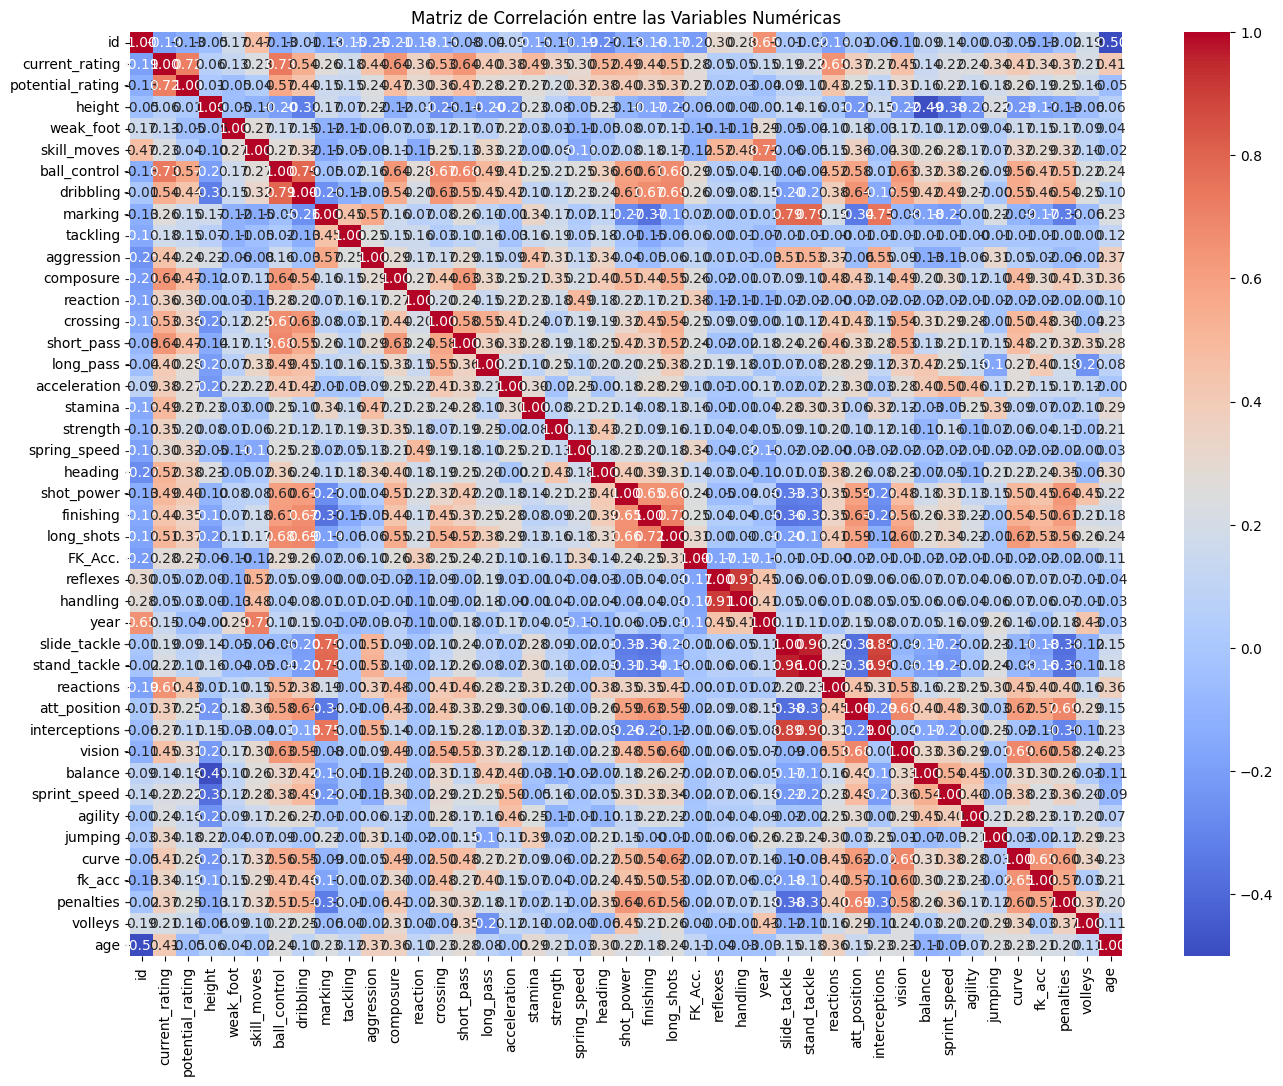

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar solo las variables numéricas para la matriz de correlación
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Calcular la matriz de correlación
correlation_matrix = df[numeric_columns].corr()

# Mostrar la matriz de correlación utilizando un heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre las Variables Numéricas')
plt.show()


A continuación se realiza una selección de características basada en la correlación con la variable objetivo, current_rating. Primero, se identifican todas las columnas numéricas en el DataFrame y se calcula la correlación de cada una con current_rating, tomando solo los valores absolutos de la correlación. A continuación, se define un umbral de correlación (0.25) para considerar solo aquellas variables que tengan una correlación significativa con el objetivo. Las columnas que cumplen con este umbral se seleccionan y se guardan en un nuevo DataFrame (df_selected_corr). Luego, se identifican y agregan al DataFrame filtrado las columnas categóricas que fueron transformadas a variables dummy (como simplified_positions, preferred_foot, y work_rate), para conservar información relevante de estas categorías en el modelo. Finalmente, se imprimen las variables seleccionadas según el criterio de correlación.

In [ ]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Calcular la correlación de todas las variables numéricas con la variable objetivo 'current_rating'
correlation_with_target = df[numeric_columns].corr()['current_rating'].abs()

# Definir el umbral para la correlación significativa
threshold = 0.25

# Seleccionar las variables con una correlación mayor o igual al umbral
selected_features_corr = correlation_with_target[correlation_with_target >= threshold].index.tolist()

# Filtrar el DataFrame para mantener solo las variables seleccionadas
df_selected_corr = df[selected_features_corr]

# Añadir las variables dumificadas al DataFrame filtrado
dumified_columns = [col for col in df.columns if col.startswith(('simplified_positions_', 'preferred_foot_', 'work_rate_'))]

# Concatenar las columnas dumificadas al DataFrame filtrado
df_selected_corr = pd.concat([df_selected_corr, df[dumified_columns]], axis=1)
print("Variables seleccionadas basadas en la correlación con 'current_rating' (≥ 0.25):")
print(selected_features_corr)


Variables seleccionadas basadas en la correlación con 'current_rating' (≥ 0.25):
['current_rating', 'potential_rating', 'ball_control', 'dribbling', 'marking', 'aggression', 'composure', 'reaction', 'crossing', 'short_pass', 'long_pass', 'acceleration', 'stamina', 'strength', 'spring_speed', 'heading', 'shot_power', 'finishing', 'long_shots', 'FK_Acc.', 'reactions', 'att_position', 'interceptions', 'vision', 'jumping', 'curve', 'fk_acc', 'penalties', 'age']


## Modelos

A continuación se crearán varios modelos de regresión lineal para predecir el rendimiento de los jugadores.

Primero se selecciona una lista de jugadores conocidos y se crean dos DataFrames: uno con estos jugadores y otro con los restantes. Luego, divide el conjunto de jugadores restantes en un conjunto de entrenamiento (80%) y uno de prueba (20%). A continuación, se añaden los jugadores conocidos al conjunto de prueba. Se establecen varios modelos de regresión para evaluar el rendimiento en la predicción de las calificaciones actuales de los jugadores. Finalmente, se crea un diccionario para almacenar los resultados de los modelos, incluyendo el error cuadrático medio y el coeficiente de determinación.

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Lista de jugadores conocidos
jugadores_conocidos = ['Cristiano Ronaldo', 'Sergio Ramos', 'Dani Alves', 'Lionel Messi', 'Neymar']

# Crear DataFrame para jugadores conocidos
df_jugadores_conocidos = df[df['Fullname'].isin(jugadores_conocidos)]

# Crear DataFrame para jugadores restantes
df_resto = df[~df['Fullname'].isin(jugadores_conocidos)]

# Dividir el conjunto restante en entrenamiento (80%) y prueba (20%)
X_resto = df_resto[df_selected_corr.columns]  # Usar las columnas de df_selected_corr
y_resto = df_resto['current_rating']
X_train_resto, X_test_resto, y_train_resto, y_test_resto = train_test_split(X_resto, y_resto, test_size=0.2, random_state=42)

# Agregar los jugadores conocidos al conjunto de prueba
X_test = pd.concat([X_test_resto, df_jugadores_conocidos[df_selected_corr.columns]])  # Usar las mismas características seleccionadas
y_test = pd.concat([y_test_resto, df_jugadores_conocidos['current_rating']])

# El conjunto de entrenamiento se queda con el 80% de los jugadores restantes
X_train = X_train_resto
y_train = y_train_resto

# Modelos con regularización y ajustes
modelos = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Bayesian Ridge': BayesianRidge(),
    'SVR': SVR(kernel='linear', C=0.5, epsilon=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Regresión Polinomial (grado 2)': make_pipeline(PolynomialFeatures(2), Ridge(alpha=1.0))
}

# Diccionario para almacenar los resultados
resultados = {
    'Jugador': [],
    'Modelo': [],
    'MSE': [],
    'R2': []
}



A continuación se itera sobre el conjunto de modelos de regresión, ajustando cada uno con los datos de entrenamiento. Luego, se predice las calificaciones en el conjunto de prueba completo y se calcula el error cuadrático medio y el coeficiente de determinación para cada modelo.

In [ ]:
for nombre_modelo, modelo in modelos.items():
    modelo.fit(X_train, y_train)

    # Predecir los valores para todo el conjunto de prueba
    y_pred_test = modelo.predict(X_test)

    # Calcular las métricas en el conjunto de prueba completo
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    # Guardar los resultados para todo el conjunto de prueba
    resultados['Jugador'].append('Conjunto de Prueba Completo')
    resultados['Modelo'].append(nombre_modelo)
    resultados['MSE'].append(mse)
    resultados['R2'].append(r2)
resultados_df = pd.DataFrame(resultados)
print(resultados_df)

                       Jugador                          Modelo           MSE  \
0  Conjunto de Prueba Completo                Ridge Regression  3.846269e-12   
1  Conjunto de Prueba Completo                Lasso Regression  1.663278e-04   
2  Conjunto de Prueba Completo                  Bayesian Ridge  1.952025e-27   
3  Conjunto de Prueba Completo                             SVR  1.123554e-03   
4  Conjunto de Prueba Completo                   Random Forest  1.512559e-04   
5  Conjunto de Prueba Completo                   Decision Tree  1.208985e-01   
6  Conjunto de Prueba Completo  Regresión Polinomial (grado 2)  1.854907e-09   

         R2  
0  1.000000  
1  0.999997  
2  1.000000  
3  0.999982  
4  0.999998  
5  0.998031  
6  1.000000  


Y por último se grafican las regresiones.

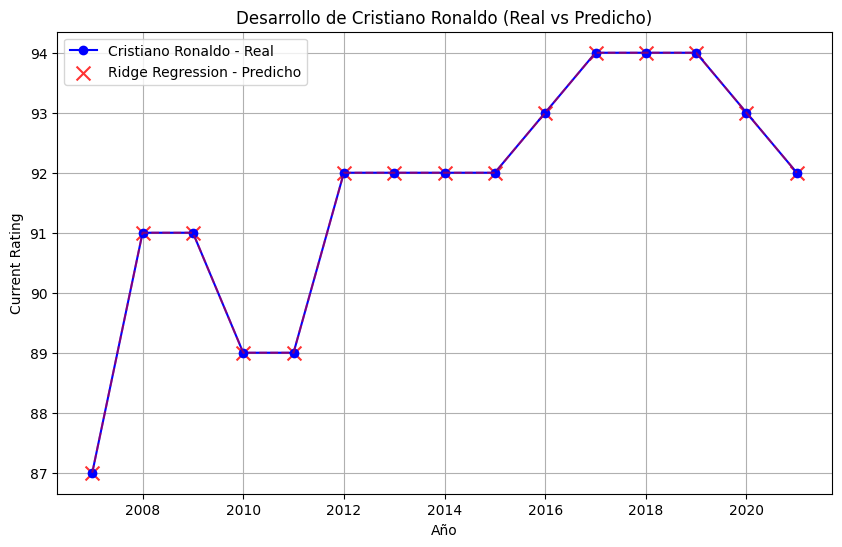

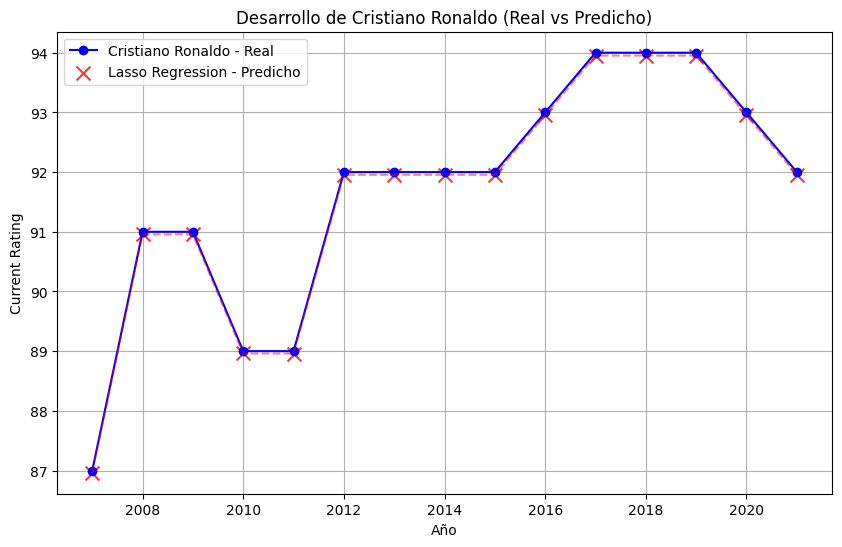

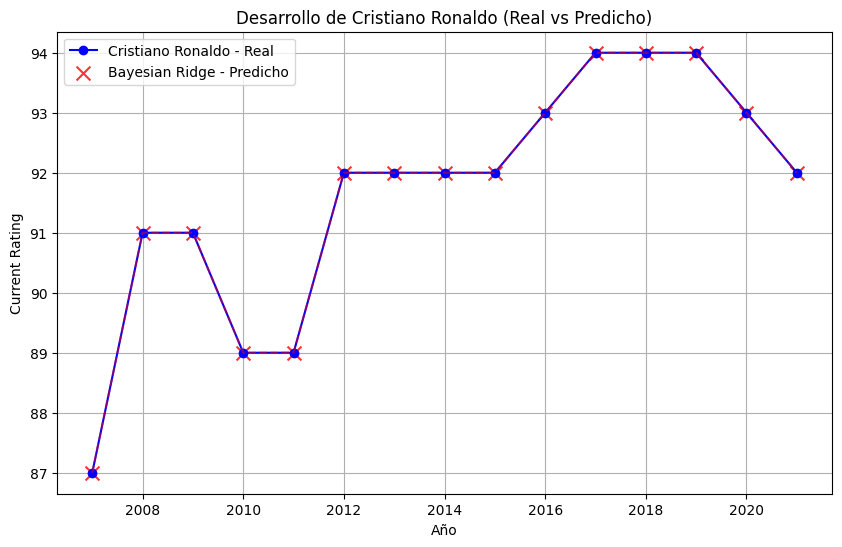

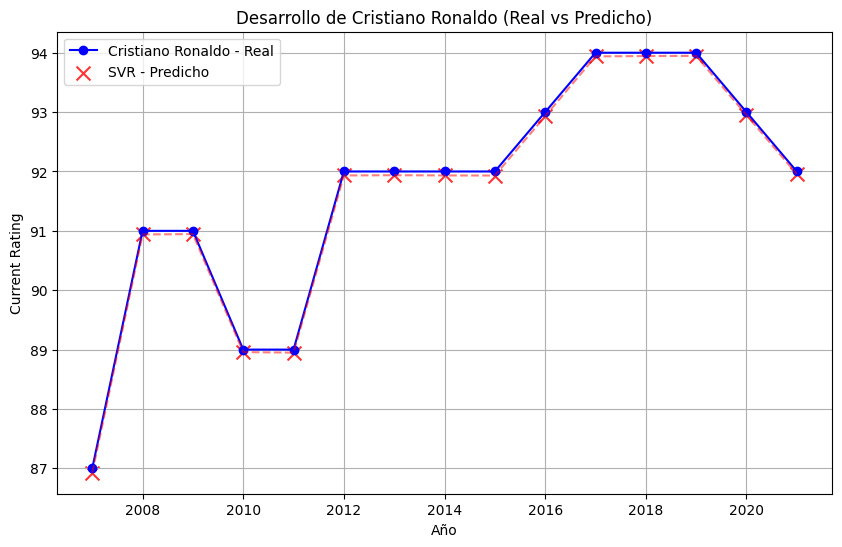

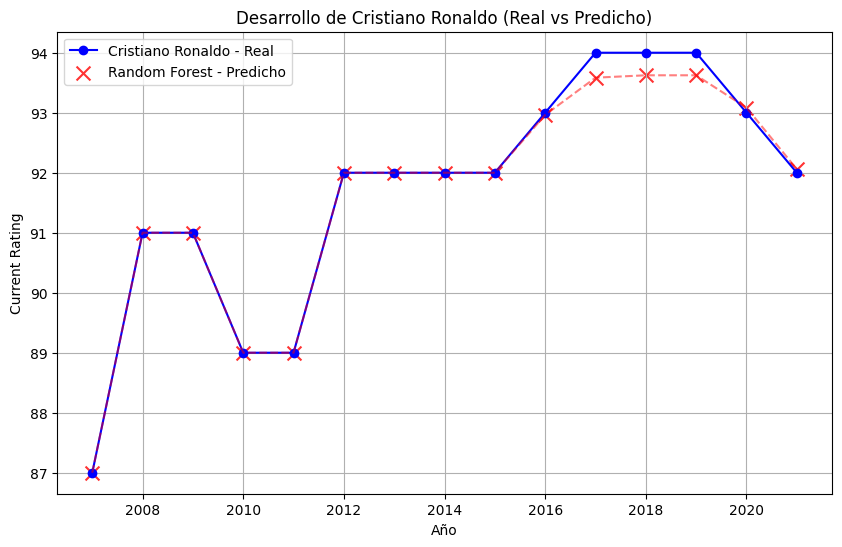

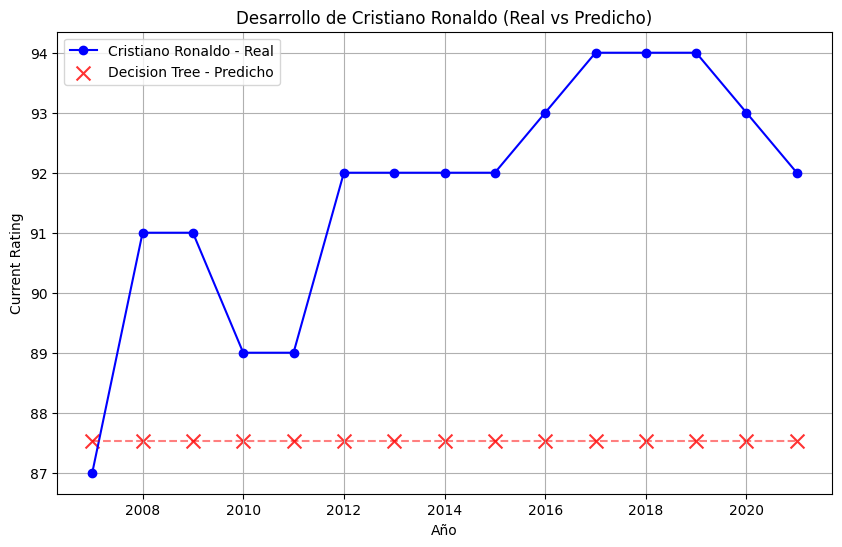

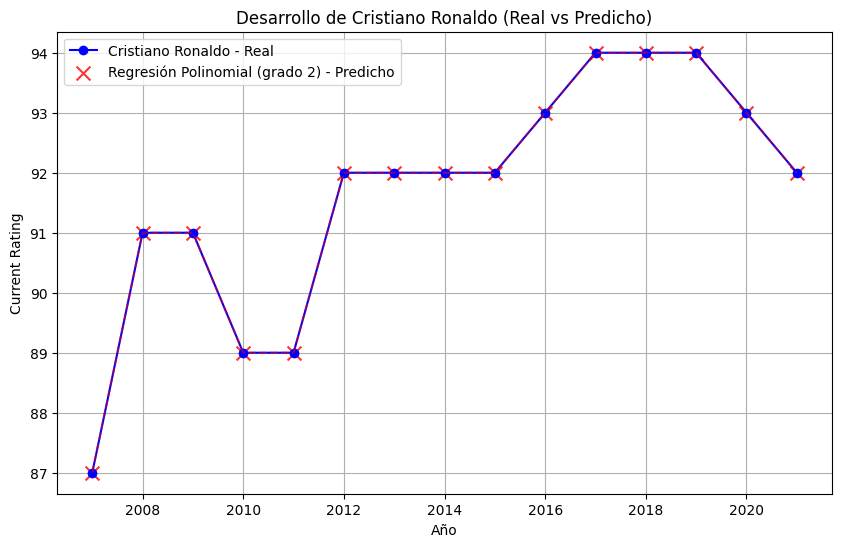

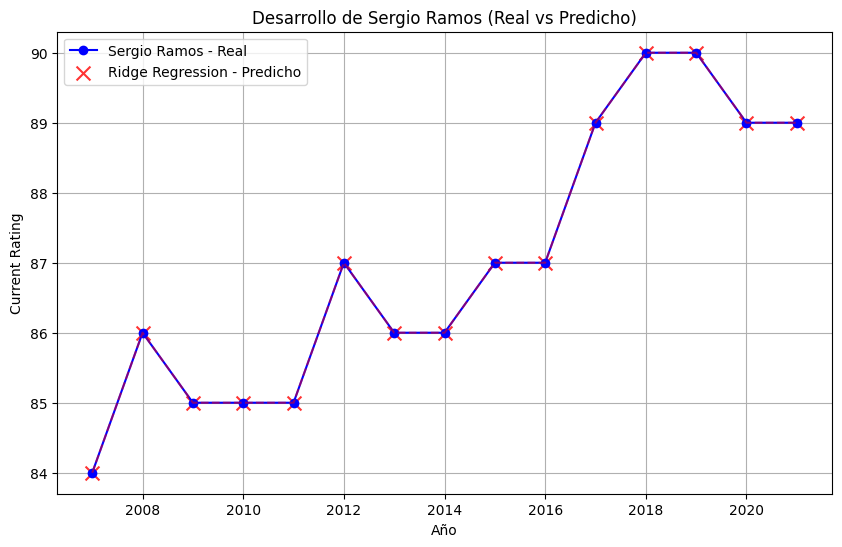

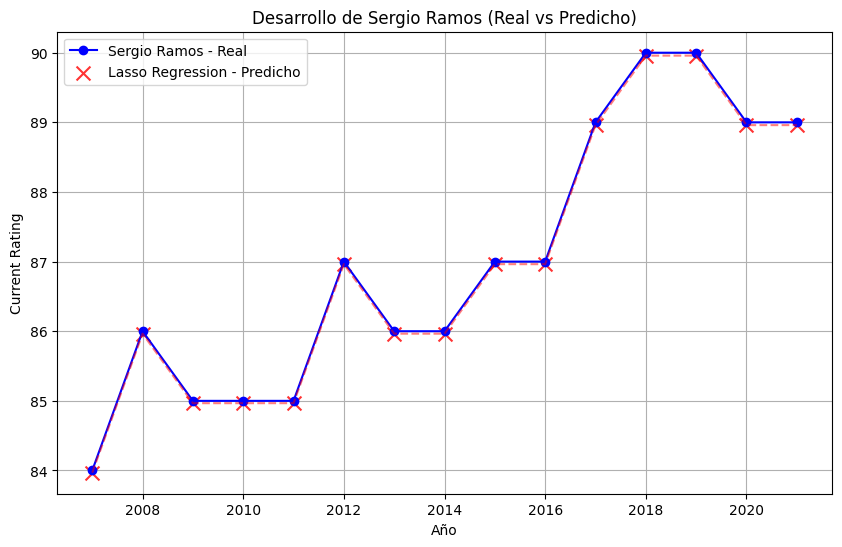

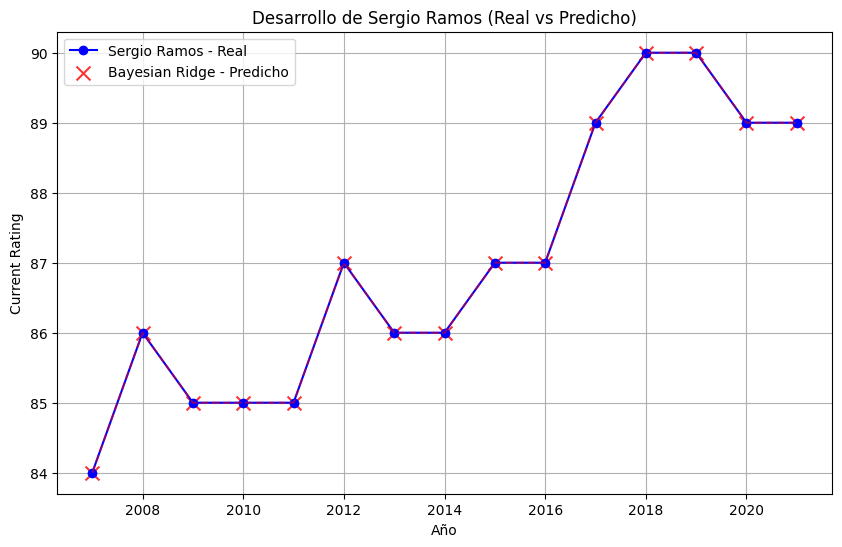

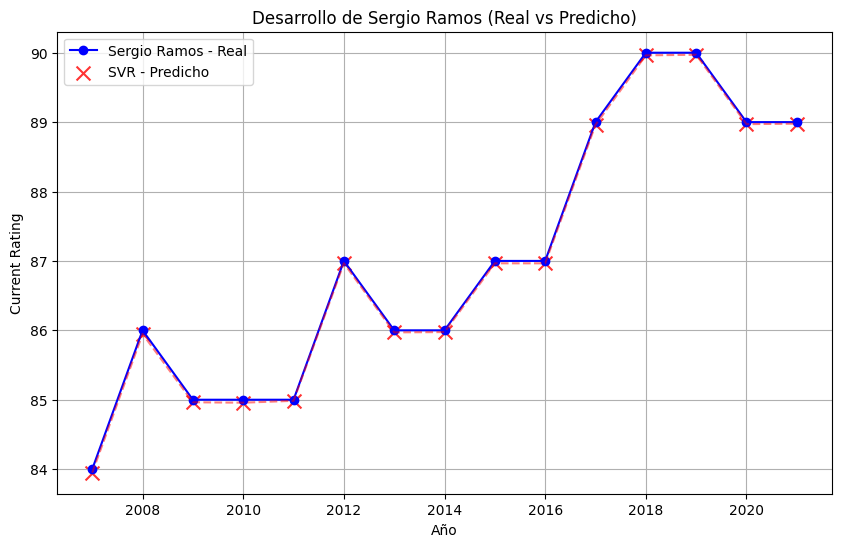

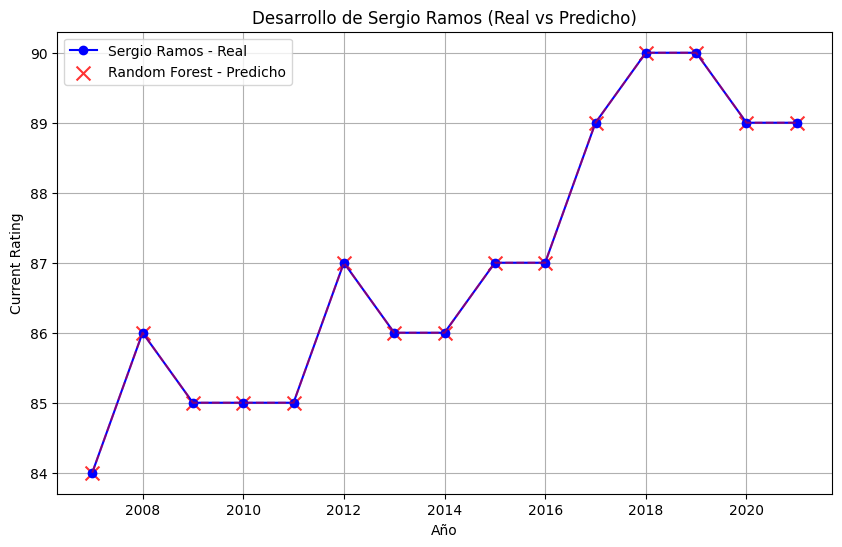

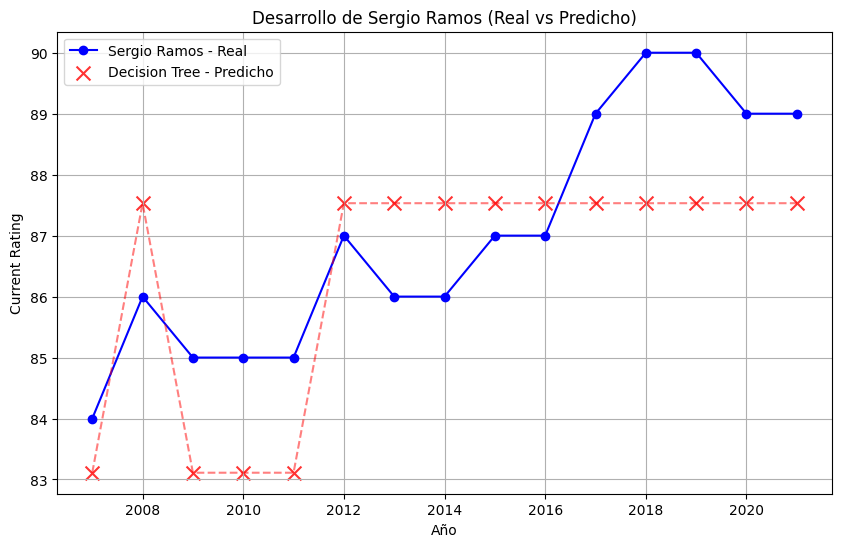

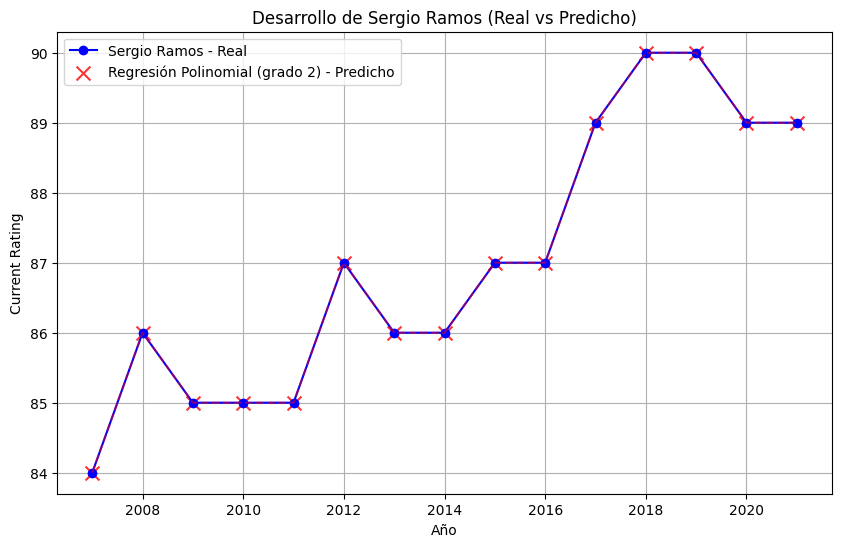

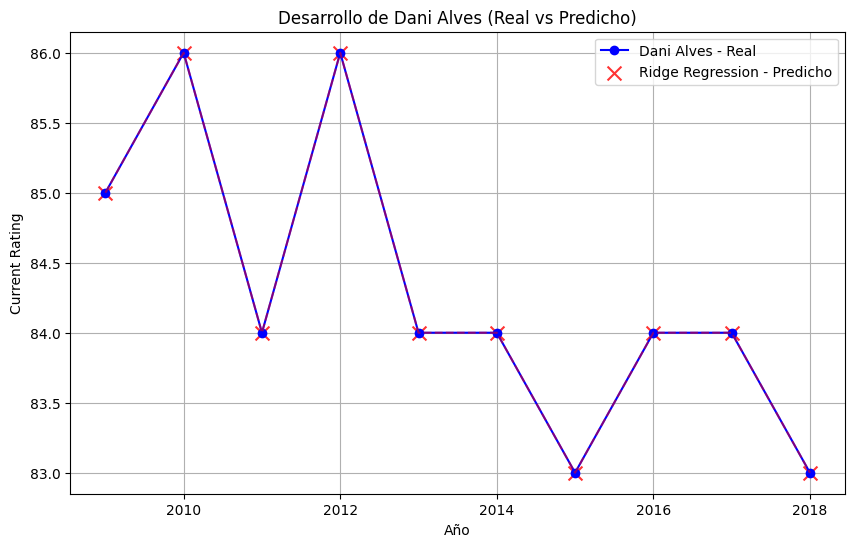

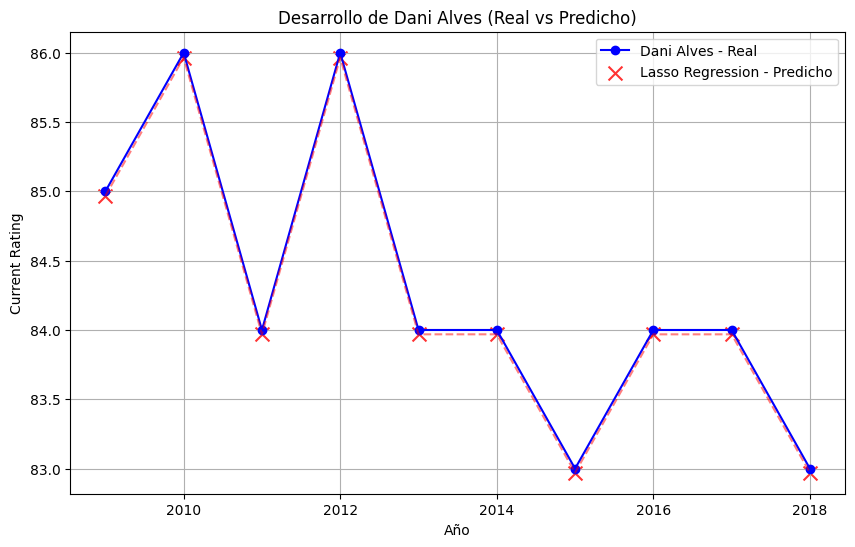

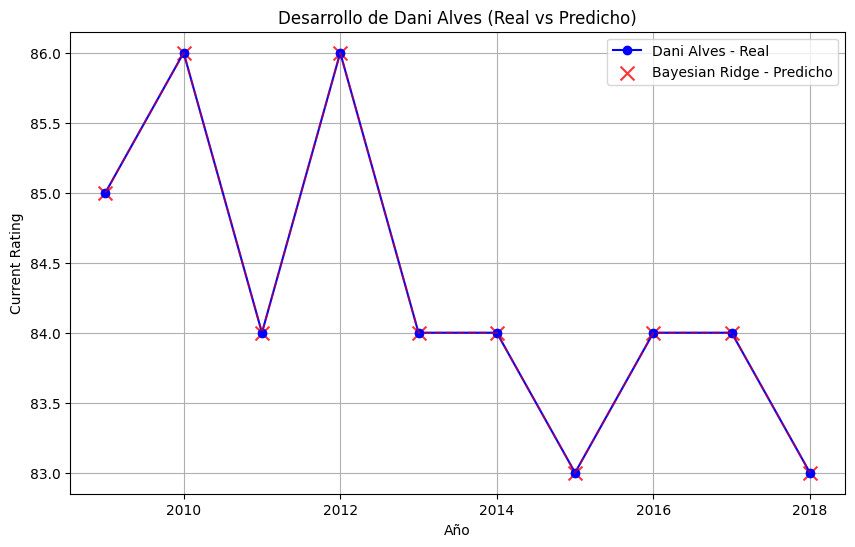

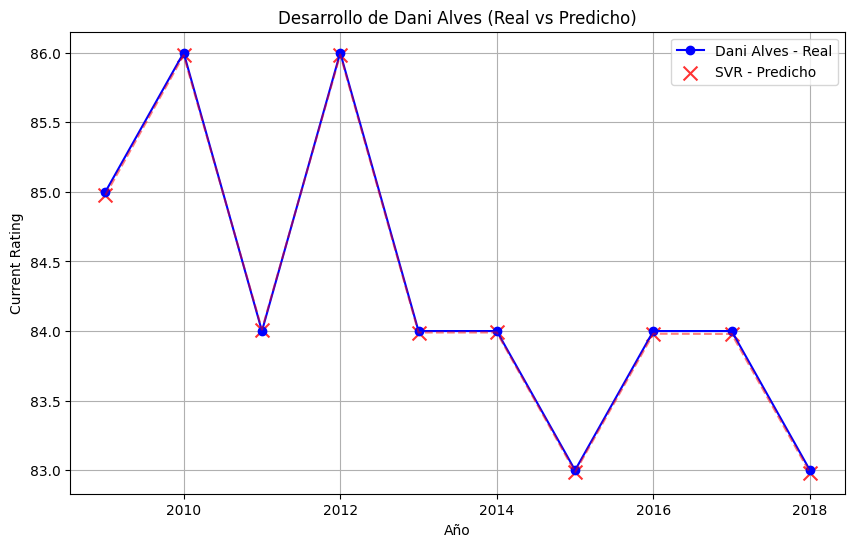

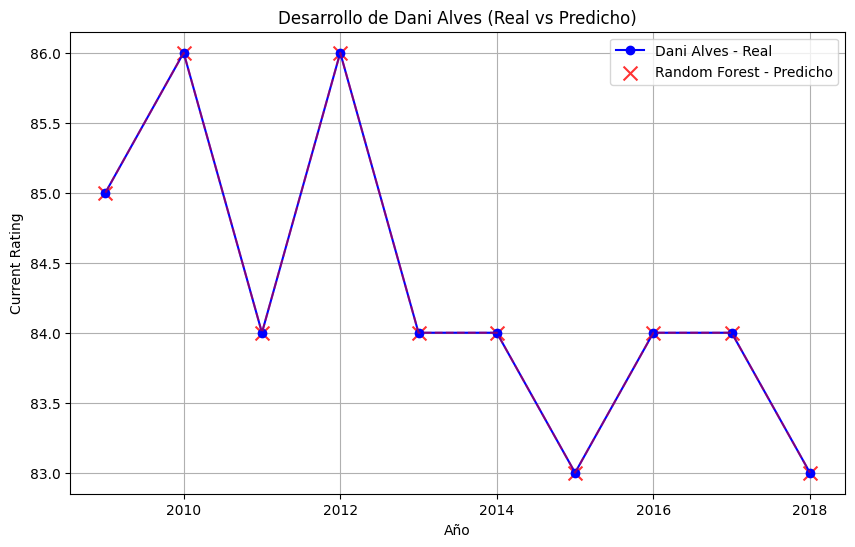

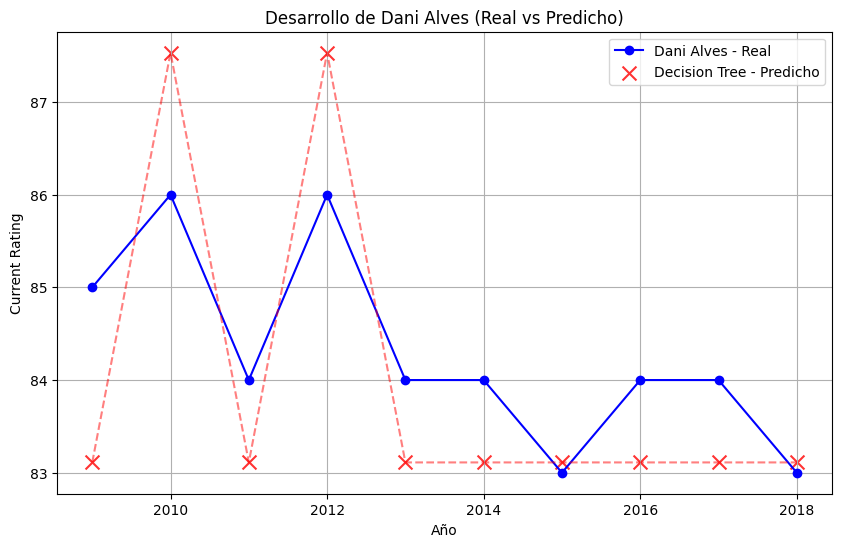

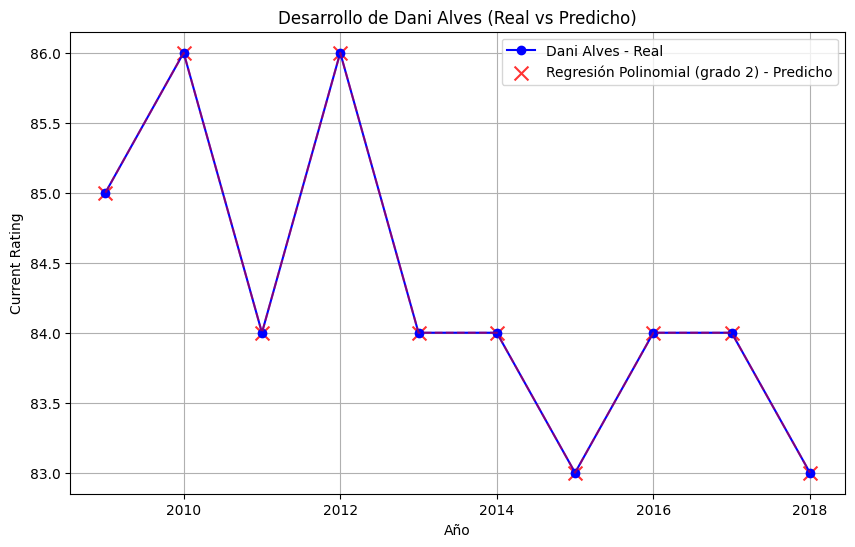

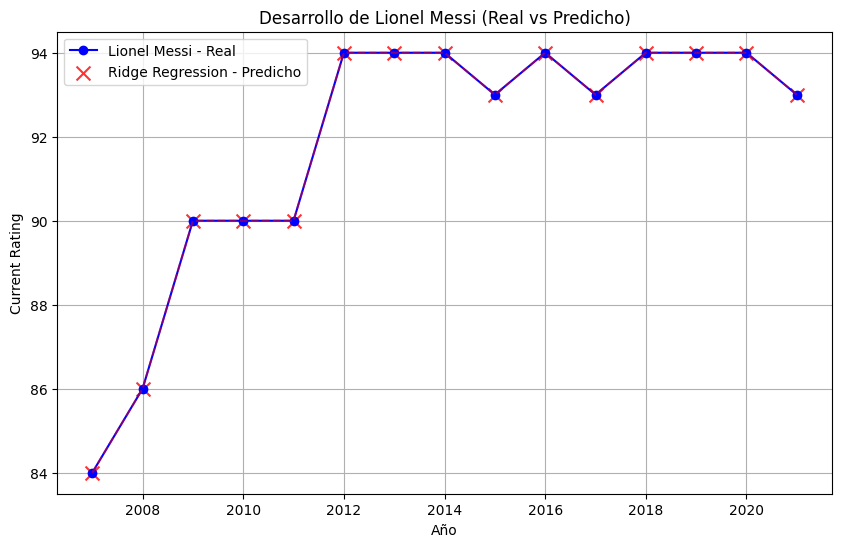

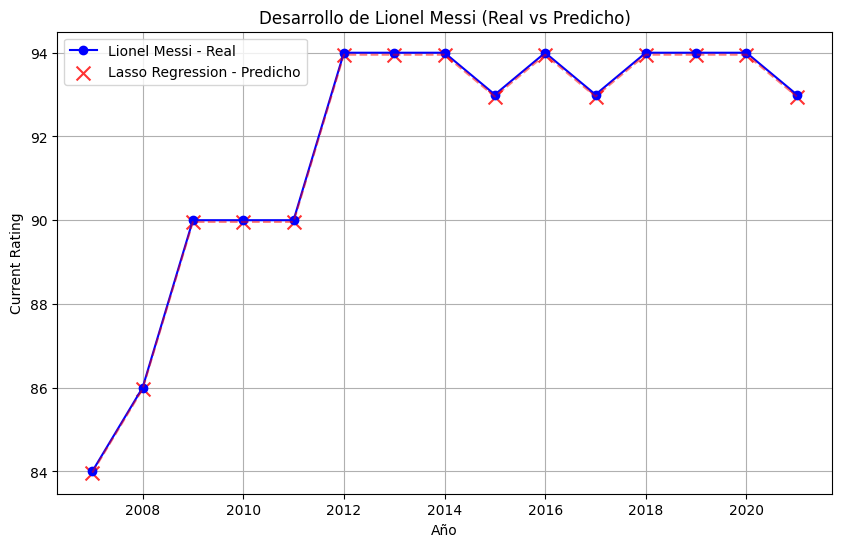

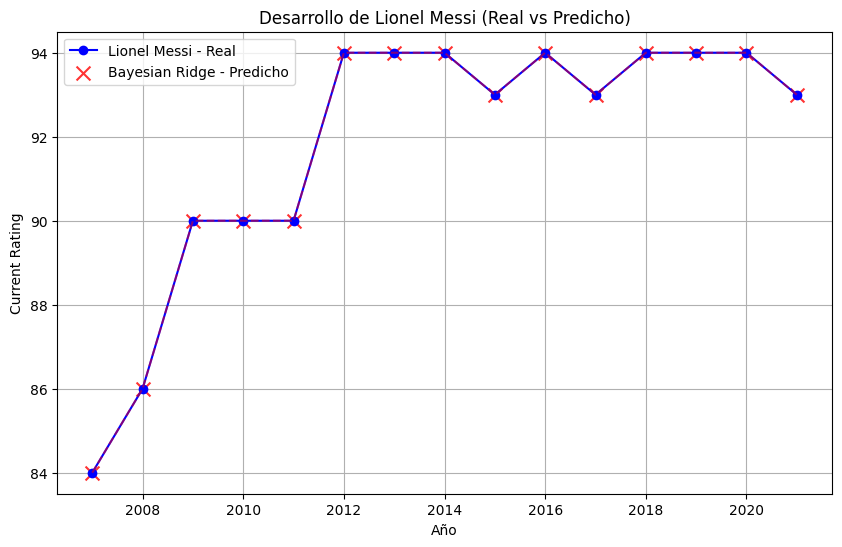

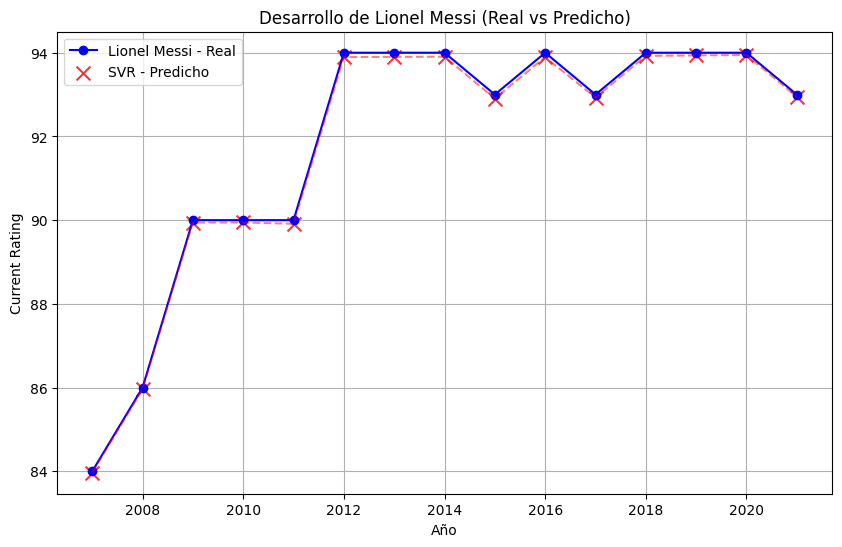

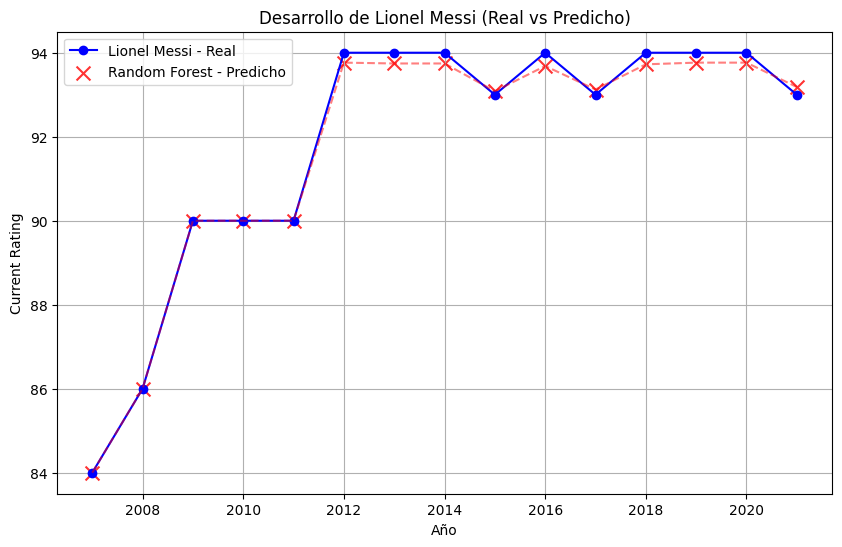

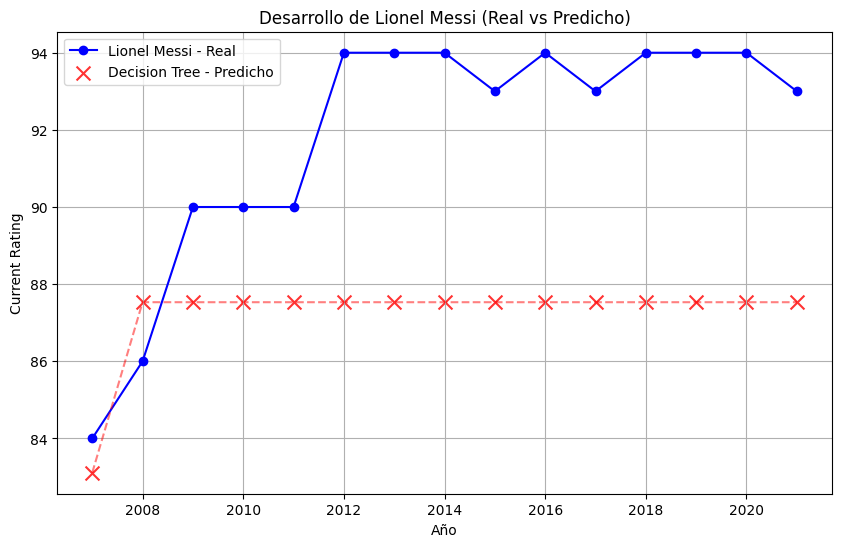

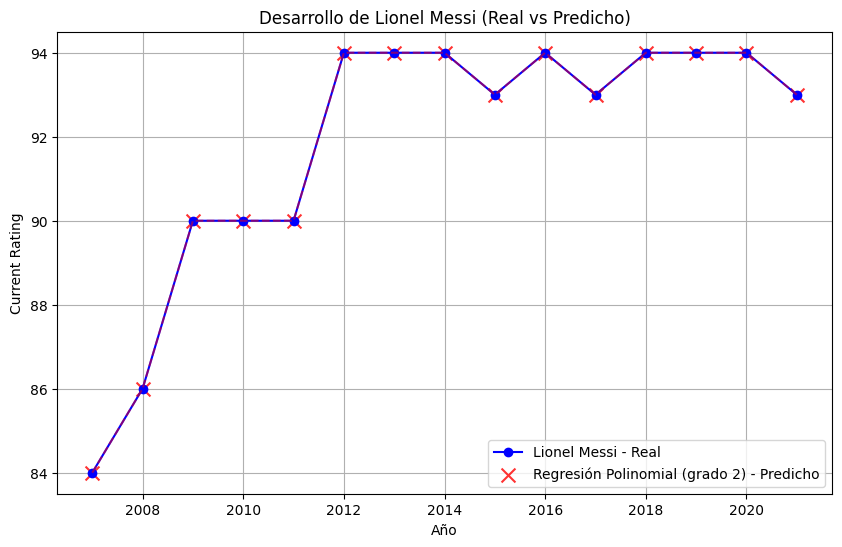

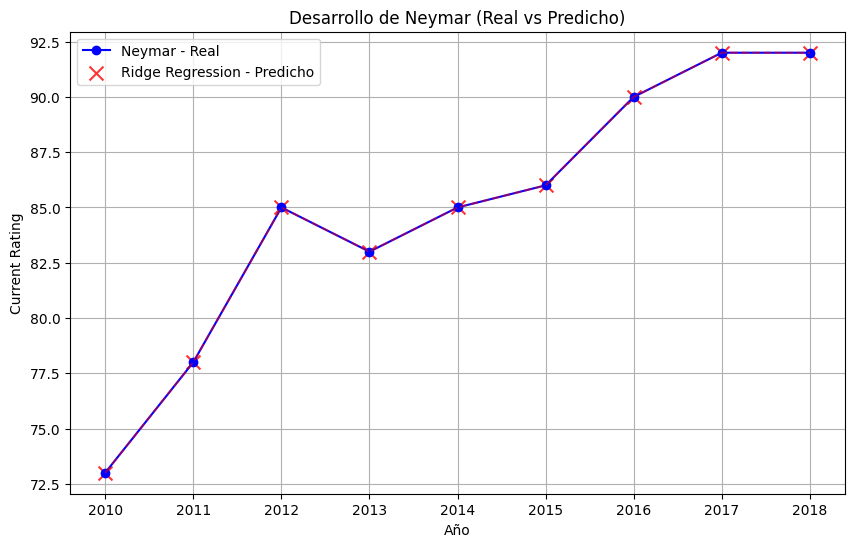

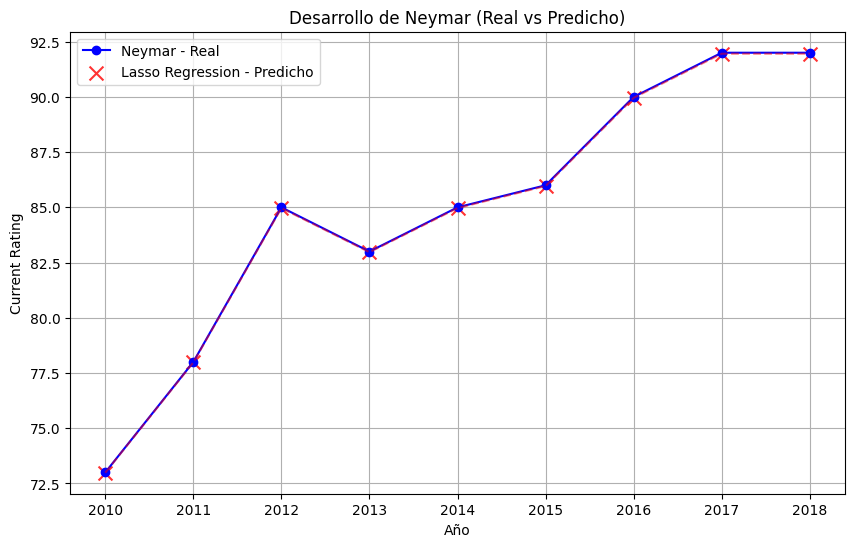

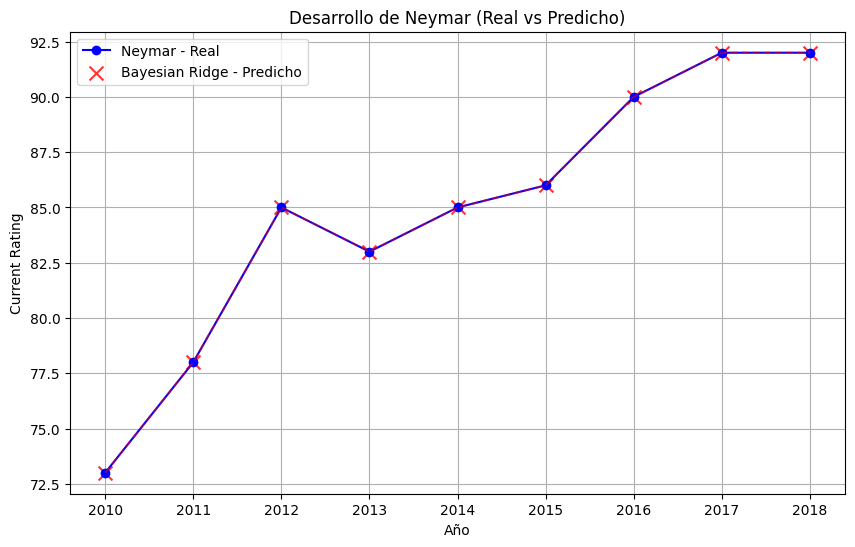

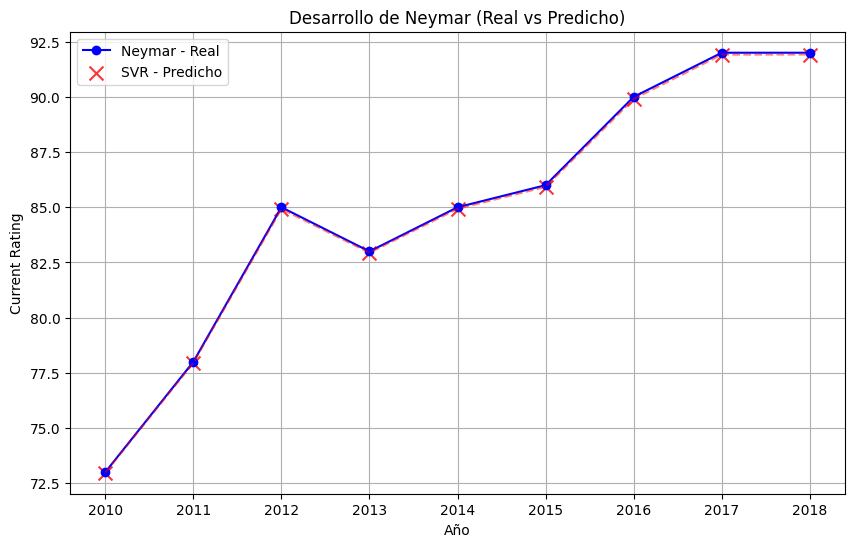

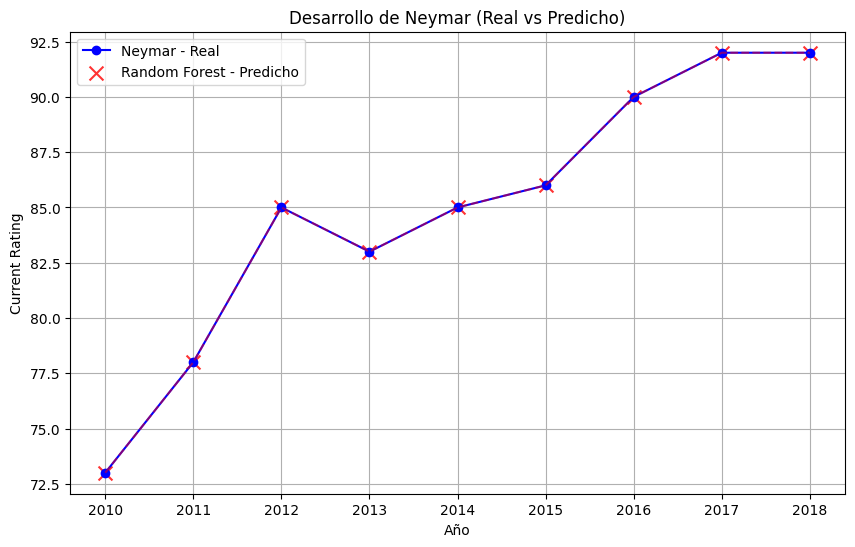

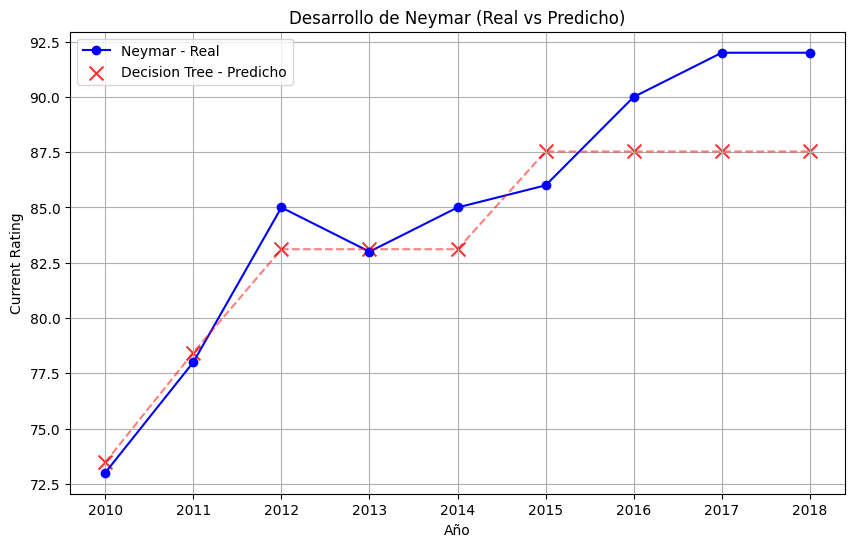

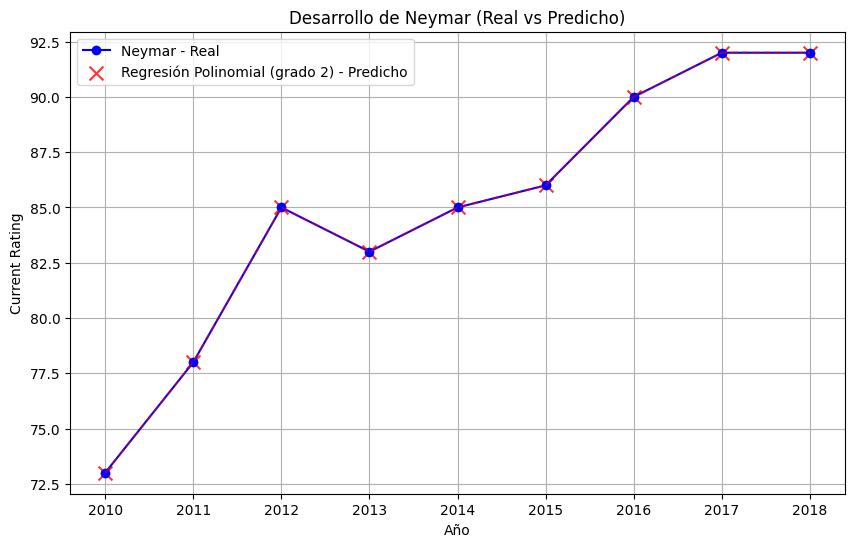

                       Jugador                          Modelo           MSE  \
0  Conjunto de Prueba Completo                Ridge Regression  3.846269e-12   
1  Conjunto de Prueba Completo                Lasso Regression  1.663278e-04   
2  Conjunto de Prueba Completo                  Bayesian Ridge  1.952025e-27   
3  Conjunto de Prueba Completo                             SVR  1.123554e-03   
4  Conjunto de Prueba Completo                   Random Forest  1.512559e-04   
5  Conjunto de Prueba Completo                   Decision Tree  1.208985e-01   
6  Conjunto de Prueba Completo  Regresión Polinomial (grado 2)  1.854907e-09   

         R2  
0  1.000000  
1  0.999997  
2  1.000000  
3  0.999982  
4  0.999998  
5  0.998031  
6  1.000000  


In [ ]:
for jugador in jugadores_conocidos:
    df_jugador = df_jugadores_conocidos[df_jugadores_conocidos['Fullname'] == jugador]

    for nombre_modelo, modelo in modelos.items():
        # Predecir los valores para los jugadores conocidos
        X_jugador = df_jugador[df_selected_corr.columns]  # Usar las columnas seleccionadas
        y_jugador = df_jugador['current_rating']
        y_pred_jugador = modelo.predict(X_jugador)

        # Graficar los resultados para este jugador
        plt.figure(figsize=(10, 6))

        # Gráfico de los valores reales
        plt.plot(df_jugador['year'], y_jugador, marker='o', linestyle='-', color='blue', label=f'{jugador} - Real')

        # Gráfico de los valores predichos (con mayor tamaño de puntos y diferente color)
        plt.scatter(df_jugador['year'], y_pred_jugador, marker='x', color='red', s=100, label=f'{nombre_modelo} - Predicho', alpha=0.8)
        plt.plot(df_jugador['year'], y_pred_jugador, linestyle='--', color='red', alpha=0.5)

        plt.title(f'Desarrollo de {jugador} (Real vs Predicho)')
        plt.xlabel('Año')
        plt.ylabel('Current Rating')
        plt.legend()
        plt.grid(True)
        plt.show()

# Mostrar los resultados en un DataFrame con todo el conjunto de prueba incluido
resultados_df = pd.DataFrame(resultados)
print(resultados_df)


## Normalización

In [ ]:
df_selected_corr = pd.concat([df[['id', 'Fullname','year']], df_selected_corr], axis=1)

# Verificar el resultado
df_selected_corr.head()

id          Fullname  year  current_rating  potential_rating  \
0    3721      Nenad Dzodic  2005              68                80   
1  146781        AranzÃ¡bal  2005              80                85   
4  150655  Gilles Yapi Yapo  2005              79                84   
5     729         Igli Tare  2005              64                74   
6  139776         Gladstone  2005              71                81   

   ball_control  dribbling  marking  aggression  composure  ...  FK_Acc.  \
0            68         52       74          63         58  ...     57.0   
1            75         35       84          75         68  ...     55.0   
4            75         89       54          60         70  ...     60.0   
5            78         55       29          74         86  ...     56.0   
6            45         25       75          69         52  ...     52.0   

   reactions  att_position  interceptions     vision    jumping      curve  \
0  61.533969     49.648453      46.577839  52.834957  58.796288  45.727156   
1  61.533969     49.648453      46.577839  52.834957  58.796288  45.727156   
4  61.533969     49.648453      46.577839  52.834957  58.796288  45.727156   
5  61.533969     49.648453      46.577839  52.834957  58.796288  45.727156   
6  61.533969     49.648453      46.577839  52.834957  58.796288  45.727156   

      fk_acc  penalties   age  
0  46.045577   46.24457  28.0  
1  46.045577   46.24457  32.0  
4  46.045577   46.24457  23.0  
5  46.045577   46.24457  32.0  
6  46.045577   46.24457  20.0  

[5 rows x 32 columns]

In [ ]:
print(df_selected_corr.columns)

Index(['id', 'Fullname', 'year', 'current_rating', 'potential_rating',
       'ball_control', 'dribbling', 'marking', 'aggression', 'composure',
       'reaction', 'crossing', 'short_pass', 'long_pass', 'acceleration',
       'stamina', 'strength', 'spring_speed', 'heading', 'shot_power',
       'finishing', 'long_shots', 'FK_Acc.', 'reactions', 'att_position',
       'interceptions', 'vision', 'jumping', 'curve', 'fk_acc', 'penalties',
       'age'],
      dtype='object')


A continuación se normalizan los datos excluyendo "id" y "year".

In [ ]:
numeric_columns = df_selected_corr.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in ['id', 'year']]

# Aplicar normalización solo a las columnas numéricas seleccionadas
scaler = StandardScaler()
df_selected_corr[numeric_columns] = scaler.fit_transform(df_selected_corr[numeric_columns])


## Red Neuronal Recurrente GRU (RNN GRU)

Ahora se desarrollará la RNN de tipo unidades recurrentes cerradas (GRU) para predecir mejor las estadísticas de los jugadores.

Primero se crean secuencias de datos para cada jugador, si hay suficientes registros (al menos sequence_length + 1), se extraen secuencias de longitud sequence_length de las columnas numéricas. Cada secuencia se almacena junto con su correspondiente valor objetivo (current_rating) y el ID del jugador. Esto resulta en tres listas: sequences para las características, targets para los valores a predecir y ids para identificar a cada jugador.

In [ ]:
sequence_length = 5
sequences, targets, ids = [], [], []

# Asegurarse de no reasignar `df_selected_corr` a `df` ordenado
df_selected_corr = df_selected_corr.sort_values(by=['id', 'year']).reset_index(drop=True)

# Crear las secuencias sin columnas no numéricas
for player_id, group in df_selected_corr.groupby('id'):
    group = group.reset_index(drop=True)
    if len(group) >= sequence_length + 1:
        for start in range(len(group) - sequence_length):
            sequence_data = group.iloc[start:start + sequence_length]
            # Incluir solo columnas numéricas
            X_sequence = sequence_data[numeric_columns].values
            y_value = group.iloc[start + sequence_length]['current_rating']
            sequences.append(X_sequence)
            targets.append(y_value)
            ids.append(player_id)

Ahora se aplica padding para que todas las secuencias tengan la misma longitud y luego se divide en datos de entrenamiento (80%) y validación (20%).

In [ ]:
# Convertir secuencias y aplicar padding
X = np.array(sequences)
y = np.array(targets)
X_padded = pad_sequences(X, maxlen=sequence_length, padding='post', dtype='float32')
ids = np.array(ids)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X_padded, y, ids, test_size=0.2, random_state=42)


A continuación se define el modelo de red neuronal recurrente utilizando Keras, comienza con una capa de Masking para ignorar valores cero en las secuencias, luego, añade dos capas bidireccionales de GRU (Gated Recurrent Unit) con diferentes tamaños, intercaladas con capas de Dropout para prevenir el sobreajuste, seguida por dos capas densas, donde la última produce una única salida. El modelo se compila utilizando el optimizador Adam con una tasa de aprendizaje de 0.0001 y se establece la pérdida como el error cuadrático medio (MSE). También se configuran callbacks para detener el entrenamiento temprano si la pérdida de validación no mejora y para guardar el mejor modelo durante el entrenamiento.

In [ ]:
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(GRU(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Dropout(0.4))
model.add(GRU(32, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')



Se entrena el modelo.

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop, checkpoint])



Epoch 1/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 91s 57ms/step - loss: 0.2454 - val_loss: 0.0875
Epoch 2/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 60s 45ms/step - loss: 0.1203 - val_loss: 0.0883
Epoch 3/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 80s 43ms/step - loss: 0.1047 - val_loss: 0.0876
Epoch 4/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 53s 40ms/step - loss: 0.0964 - val_loss: 0.0799
Epoch 5/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 61s 46ms/step - loss: 0.0921 - val_loss: 0.0837
Epoch 6/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 76s 41ms/step - loss: 0.0887 - val_loss: 0.0806
Epoch 7/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 80s 40ms/step - loss: 0.0834 - val_loss: 0.0837
Epoch 8/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - loss: 0.0819 - val_loss: 0.0764
Epoch 9/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - loss: 0.0798 - val_loss: 0.0793
Epoch 10/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - loss: 0.0787 - val_loss: 0.0799
Epoch 11/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - loss: 0.0782 - val_loss: 0.08

In [ ]:
model.load_weights('best_model.keras')

test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0767
Test Loss: 0.07639536261558533


A continuación se evalúa el modelo utilizando el error cuadrático medio (MSE), la raíz del error cuadrático medio (RMSE), el error absoluto medio (MAE) y el coeficiente de determinación (R²).

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
y_pred = model.predict(X_test).flatten()
current_rating_index = numeric_columns.index('current_rating')
current_rating_mean = scaler.mean_[current_rating_index]
current_rating_scale = scaler.scale_[current_rating_index]
y_test_original = y_test * current_rating_scale + current_rating_mean
y_pred_original = y_pred * current_rating_scale + current_rating_mean

# Evaluación de rendimiento
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print("Evaluación del modelo en el conjunto de prueba:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Evaluación del modelo en el conjunto de prueba:
MSE: 4.60
RMSE: 2.14
MAE: 1.63
R²: 0.87


A continuación se genera una grafica de dispersión.

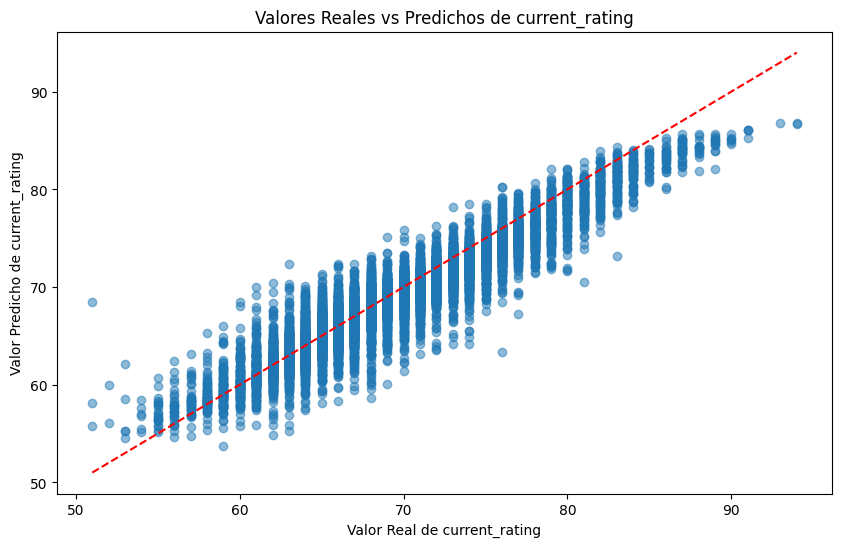

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.xlabel('Valor Real de current_rating')
plt.ylabel('Valor Predicho de current_rating')
plt.title('Valores Reales vs Predichos de current_rating')
plt.show()


Ahora se selecciona específicamente a Lionel Messi para comparar el valor real con el predicho.

In [ ]:
player_name = "Lionel Messi"
player_id = df_selected_corr[df_selected_corr['Fullname'] == player_name]['id'].iloc[0]

# Filtrar las predicciones y valores reales para ese jugador en el conjunto de prueba
player_indices = np.where(ids_test == player_id)[0]
player_y_test_original = y_test_original[player_indices]
player_y_pred_original = y_pred_original[player_indices]

# Mostrar los valores reales y predichos desnormalizados
print(f"\nPredicciones para {player_name} (valores originales):")
for i, (real, pred) in enumerate(zip(player_y_test_original, player_y_pred_original), 1):
    print(f"Secuencia {i}: Real = {real:.2f}, Predicción = {pred:.2f}")



Predicciones para Lionel Messi (valores originales):
Secuencia 1: Real = 93.00, Predicción = 86.78
Secuencia 2: Real = 94.00, Predicción = 86.72


Se hace lo mismo Falcao.

In [ ]:
player_name = "Falcao"
player_id = df_selected_corr[df_selected_corr['Fullname'] == player_name]['id'].iloc[0]

# Filtrar las predicciones y valores reales para ese jugador en el conjunto de prueba
player_indices = np.where(ids_test == player_id)[0]
player_y_test_original = y_test_original[player_indices]
player_y_pred_original = y_pred_original[player_indices]

# Mostrar los valores reales y predichos desnormalizados
print(f"\nPredicciones para {player_name} (valores originales):")
for i, (real, pred) in enumerate(zip(player_y_test_original, player_y_pred_original), 1):
    print(f"Secuencia {i}: Real = {real:.2f}, Predicción = {pred:.2f}")



Predicciones para Falcao (valores originales):
Secuencia 1: Real = 80.00, Predicción = 80.33


## RNN Ponderado

Ahora se entrena un modelo de red neuronal recurrente (RNN) ponderado. Primero, se define un umbral de calificación alta (high_rating_threshold) y asigna pesos a las muestras, otorgando un peso mayor a las calificaciones que superan este umbral. Luego, divide los datos en conjuntos de entrenamiento y prueba, incluyendo los pesos de las muestras.

Se crea un modelo RNN con varias capas bidireccionales de LSTM y GRU, intercaladas con capas de Dropout para evitar el sobreajuste. El modelo se compila utilizando el optimizador Adam con una tasa de aprendizaje baja y la pérdida se establece como el error cuadrático medio (MSE).

Se configuran callbacks para detener el entrenamiento anticipadamente si la pérdida de validación no mejora y para guardar el mejor modelo. Finalmente, el modelo se entrena usando los datos de entrenamiento, incluyendo los pesos de las muestras, durante un máximo de 100 épocas y con un tamaño de lote de 32.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Masking, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

high_rating_threshold = 85

sample_weights = np.where(y >= high_rating_threshold, 1.5, 1.0)

# Split data
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X_padded, y, sample_weights, test_size=0.2, random_state=42)

# Crear el modelo RNN_Ponderado con más capas
RNN_Ponderado = Sequential()
RNN_Ponderado.add(Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])))
RNN_Ponderado.add(Bidirectional(LSTM(128, return_sequences=True)))
RNN_Ponderado.add(Dropout(0.5))
RNN_Ponderado.add(Bidirectional(LSTM(64, return_sequences=True)))
RNN_Ponderado.add(Dropout(0.4))
RNN_Ponderado.add(Bidirectional(GRU(32, return_sequences=True)))
RNN_Ponderado.add(Dropout(0.3))
RNN_Ponderado.add(GRU(16, return_sequences=False))
RNN_Ponderado.add(Dense(64, activation='relu'))
RNN_Ponderado.add(Dense(1))

# Compile el modelo con una tasa de aprendizaje baja y pérdida ponderada
RNN_Ponderado.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Configurar los callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_RNN_Ponderado.keras', monitor='val_loss', save_best_only=True, mode='min')

# Entrenar el modelo con sample weights
history = RNN_Ponderado.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                            sample_weight=weights_train, callbacks=[early_stop, checkpoint])

Epoch 1/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 105s 66ms/step - loss: 0.2897 - val_loss: 0.0877
Epoch 2/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 79s 60ms/step - loss: 0.0966 - val_loss: 0.0850
Epoch 3/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - loss: 0.0870 - val_loss: 0.0776
Epoch 4/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - loss: 0.0833 - val_loss: 0.0742
Epoch 5/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 86s 61ms/step - loss: 0.0792 - val_loss: 0.0712
Epoch 6/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 78s 58ms/step - loss: 0.0761 - val_loss: 0.0700
Epoch 7/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 84s 60ms/step - loss: 0.0741 - val_loss: 0.0691
Epoch 8/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 77s 58ms/step - loss: 0.0734 - val_loss: 0.0725
Epoch 9/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 87s 62ms/step - loss: 0.0723 - val_loss: 0.0707
Epoch 10/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 137s 59ms/step - loss: 0.0720 - val_loss: 0.0677
Epoch 11/100
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - loss: 0.0718 - val_loss: 0.

Se hacen las predicciones con los mejores pesos.

In [ ]:
# Cargar los mejores pesos y evaluar
RNN_Ponderado.load_weights('best_RNN_Ponderado.keras')
y_pred_rnn_ponderado = RNN_Ponderado.predict(X_test).flatten()

330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step


Se desnormalizan los datos para poder leerlos y se evalúa el modelo con las mismas medidas anteriores.

In [ ]:
# Desnormalizar los valores para interpretar mejor
current_rating_index = numeric_columns.index('current_rating')
current_rating_mean = scaler.mean_[current_rating_index]
current_rating_scale = scaler.scale_[current_rating_index]
y_test_original = y_test * current_rating_scale + current_rating_mean
y_pred_rnn_ponderado_original = y_pred_rnn_ponderado * current_rating_scale + current_rating_mean

# Evaluación del modelo RNN_Ponderado
mse_rnn_ponderado = mean_squared_error(y_test_original, y_pred_rnn_ponderado_original)
mae_rnn_ponderado = mean_absolute_error(y_test_original, y_pred_rnn_ponderado_original)
r2_rnn_ponderado = r2_score(y_test_original, y_pred_rnn_ponderado_original)

print("Evaluación del modelo RNN_Ponderado:")
print(f"MSE: {mse_rnn_ponderado:.2f}")
print(f"MAE: {mae_rnn_ponderado:.2f}")
print(f"R²: {r2_rnn_ponderado:.2f}")

Evaluación del modelo RNN_Ponderado:
MSE: 3.70
MAE: 1.42
R²: 0.90


## Gradient Boosting

A continuación se entrena y evalúa un modelo de regresión de Gradient Boosting para predecir las calificaciones. Se ajusta el modelo a los datos de entrenamiento, reestructurando X_train para que sea un arreglo 2D, y se utilizan los pesos de las muestras para darle mayor importancia a ciertos datos.

Después, se predicen las calificaciones en el conjunto de prueba y se calculan las métricas de evaluación para el modelo de Gradient Boosting, usando los valores originales de current_rating para la comparación.

Finalmente, se crea un gráfico de dispersión que compara las predicciones de dos modelos: el modelo RNN ponderado y el modelo de Gradient Boosting. Se utilizan diferentes colores para cada conjunto de predicciones, y se añade una línea diagonal que indica donde los valores reales y predichos serían iguales. Esto permite visualizar y comparar el rendimiento de ambos modelos en las predicciones.


Evaluación del modelo Gradient Boosting:
MSE: 3.64
MAE: 1.40
R²: 0.90


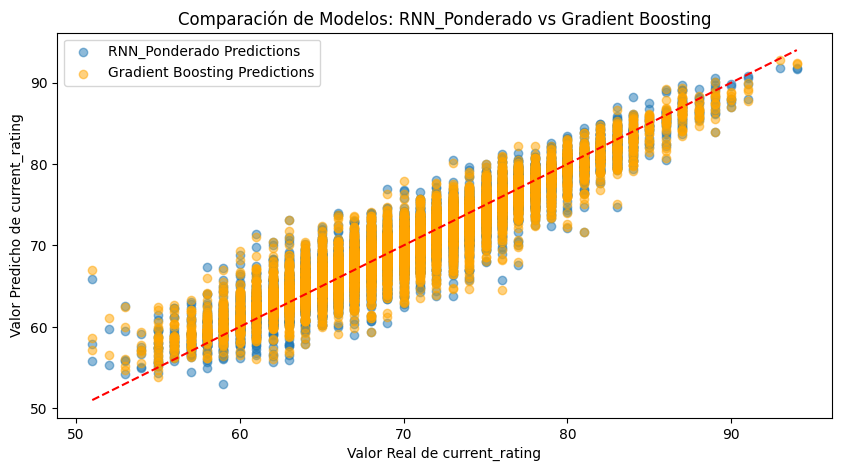

In [ ]:
# Entrenamiento y evaluación del modelo Gradient Boosting
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gbr.fit(X_train.reshape(X_train.shape[0], -1), y_train, sample_weight=weights_train)
y_pred_gbr = gbr.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluación del modelo Gradient Boosting
mse_gbr = mean_squared_error(y_test_original, y_pred_gbr * current_rating_scale + current_rating_mean)
mae_gbr = mean_absolute_error(y_test_original, y_pred_gbr * current_rating_scale + current_rating_mean)
r2_gbr = r2_score(y_test_original, y_pred_gbr * current_rating_scale + current_rating_mean)

print("\nEvaluación del modelo Gradient Boosting:")
print(f"MSE: {mse_gbr:.2f}")
print(f"MAE: {mae_gbr:.2f}")
print(f"R²: {r2_gbr:.2f}")

# Visualización de resultados RNN_Ponderado vs Gradient Boosting
plt.figure(figsize=(10, 5))
plt.scatter(y_test_original, y_pred_rnn_ponderado_original, alpha=0.5, label="RNN_Ponderado Predictions")
plt.scatter(y_test_original, y_pred_gbr * current_rating_scale + current_rating_mean, alpha=0.5, color='orange', label="Gradient Boosting Predictions")
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.xlabel('Valor Real de current_rating')
plt.ylabel('Valor Predicho de current_rating')
plt.legend()
plt.title('Comparación de Modelos: RNN_Ponderado vs Gradient Boosting')
plt.show()

Ahora se muestran las predicciones de nuevo para Lionel Messi, pero esta vez con el RNN ponderado.


In [ ]:
# Suponiendo que ya tenemos el modelo RNN_Ponderado entrenado y las predicciones realizadas
player_name = "Lionel Messi"
player_id = df_selected_corr[df_selected_corr['Fullname'] == player_name]['id'].iloc[0]

# Filtrar las predicciones y valores reales para ese jugador en el conjunto de prueba
player_indices = np.where(ids_test == player_id)[0]
player_y_test_original = y_test_original[player_indices]
player_y_pred_rnn_ponderado_original = y_pred_rnn_ponderado_original[player_indices]

# Mostrar los valores reales y predichos desnormalizados
print(f"\nPredicciones para {player_name} (valores originales) usando RNN_Ponderado:")
for i, (real, pred) in enumerate(zip(player_y_test_original, player_y_pred_rnn_ponderado_original), 1):
    print(f"Secuencia {i}: Real = {real:.2f}, Predicción = {pred:.2f}")



Predicciones para Lionel Messi (valores originales) usando RNN_Ponderado:
Secuencia 1: Real = 93.00, Predicción = 91.82
Secuencia 2: Real = 94.00, Predicción = 91.72


A continuación compara las calificaciones actuales reales y predichas de una lista de jugadores conocidos, en este caso, para Lionel Messi, Cristiano Ronaldo, Sergio Ramos, Falcao y Thiago Silva, mediante un gráfico de barras y líneas. Primero, se filtran las calificaciones reales y predicciones para los jugadores especificados, asegurándose de que cada jugador esté presente en el DataFrame original. Para cada jugador, se obtienen sus calificaciones reales y las predicciones del modelo RNN ponderado.

Se crean listas para almacenar las calificaciones reales, las predicciones y los años correspondientes. Luego, se genera un gráfico de barras para las calificaciones reales y se superpone una línea que muestra las predicciones. Los valores reales se anotan en la parte superior de cada barra junto con el año correspondiente, y las predicciones se anotan con un marcador rojo.

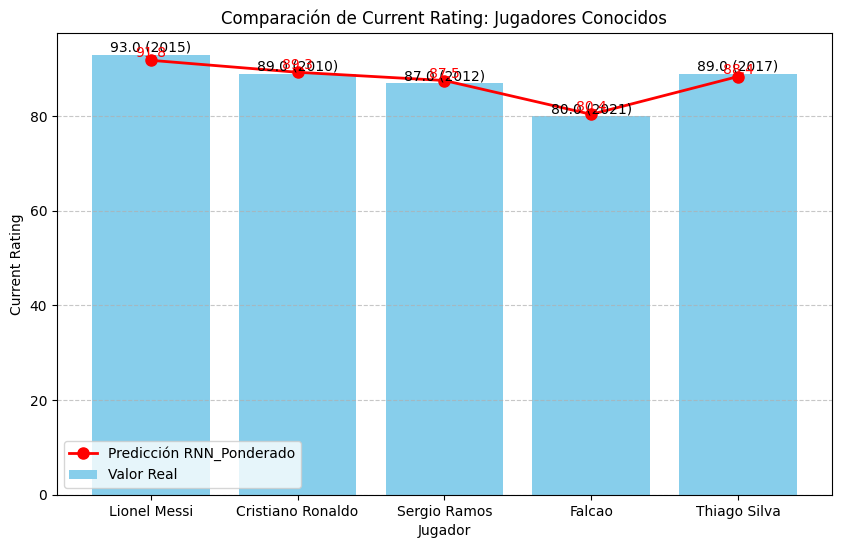

In [ ]:
import matplotlib.pyplot as plt

# Lista de jugadores conocidos
known_players = ["Lionel Messi", "Cristiano Ronaldo", "Sergio Ramos", "Falcao", "Thiago Silva"]

# Filtrar los valores reales y predichos para los jugadores conocidos en el conjunto de prueba
real_ratings = []
pred_ratings = []
years_real = []
filtered_players = []

for player in known_players:
    # Verificar si el jugador está en el DataFrame original
    if player in df['Fullname'].values:
        player_id = df[df['Fullname'] == player]['id'].iloc[0]

        # Filtrar índices en los datos de prueba
        player_indices = np.where(ids_test == player_id)[0]

        if len(player_indices) > 0:
            # Tomar el primer valor real y predicho
            real_rating = y_test_original[player_indices[0]]
            pred_rating = y_pred_rnn_ponderado_original[player_indices[0]]

            # Buscar el año en el DataFrame original para el valor real
            real_year = df[(df['id'] == player_id) & (df['current_rating'] == real_rating)]['year']
            if not real_year.empty:
                years_real.append(real_year.iloc[0])
            else:
                years_real.append("")

            # Agregar a las listas de ratings y jugadores
            real_ratings.append(real_rating)
            pred_ratings.append(pred_rating)
            filtered_players.append(player)
    else:
        print(f"{player} no está presente en el conjunto de datos original.")

# Crear la gráfica solo con los jugadores disponibles
plt.figure(figsize=(10, 6))
bars = plt.bar(filtered_players, real_ratings, color='skyblue', label="Valor Real")
plt.plot(filtered_players, pred_ratings, color='red', marker='o', linewidth=2, markersize=8, label="Predicción RNN_Ponderado")

# Añadir valores y años solo a los valores reales
for bar, real, pred, year_real in zip(bars, real_ratings, pred_ratings, years_real):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{real:.1f} ({year_real})', ha='center', va='bottom', fontsize=10)
    plt.text(bar.get_x() + bar.get_width() / 2, pred, f'{pred:.1f}', ha='center', va='bottom', fontsize=10, color='red')

# Personalizar la gráfica
plt.title("Comparación de Current Rating: Jugadores Conocidos")
plt.xlabel("Jugador")
plt.ylabel("Current Rating")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Ahora calcula el error absoluto medio (MAE) de las predicciones del modelo RNN ponderado para cada año presente en el conjunto de prueba.

In [ ]:
from sklearn.metrics import mean_absolute_error

# Crear un DataFrame de prueba que solo contenga los IDs en el conjunto de prueba
df_test = df_selected_corr[df_selected_corr['id'].isin(ids_test)]

# Inicializar diccionario para almacenar MAE por año
mae_by_year = {}

# Calcular el MAE para cada año
for year in sorted(df_test['year'].unique()):
    # Filtrar los índices del año específico en el conjunto de prueba
    year_indices = df_test[df_test['year'] == year].index
    # Asegurarnos de que los índices estén dentro del rango de `y_test_original`
    year_indices = [i for i in year_indices if i < len(y_test_original)]

    if year_indices:
        # Extraer los valores reales y predichos para el año específico
        y_real_year = y_test_original[year_indices]
        y_pred_year = y_pred_rnn_ponderado_original[year_indices]

        # Calcular MAE para el año específico y agregar al diccionario
        mae_by_year[year] = mean_absolute_error(y_real_year, y_pred_year)

# Imprimir el MAE por año
print("MAE por año:")
for year, mae in mae_by_year.items():
    print(f"{year}: {mae:.2f}")


MAE por año:
2005: 1.38
2007: 1.39
2008: 1.44
2009: 1.32
2010: 1.39
2011: 1.56
2012: 1.38
2013: 1.49
2014: 1.27
2015: 1.32
2016: 1.63
2017: 1.20
2018: 1.20
2019: 1.91
2020: 1.55
2021: 1.52


Ahora se calcula el error absoluto medio (MAE) de las predicciones del modelo RNN ponderado, pero esta vez para cada posición de fútbol.

In [ ]:
from sklearn.metrics import mean_absolute_error

# Concatenar la base de datos original con la base preprocesada en función de la columna 'id'
df_full = df.merge(df_selected_corr[['id']], on='id', how='inner')

# Filtrar el conjunto de prueba en `df_full`
df_test = df_full[df_full['id'].isin(ids_test)]

# Calcular el MAE por posición
mae_by_position = {}
positions = df_test['preferred_positions'].unique()

for position in positions:
    # Filtrar los índices de jugadores con la posición específica
    position_indices = df_test[df_test['preferred_positions'] == position].index
    # Asegurar que los índices estén dentro del rango de `y_test_original`
    position_indices = [i for i in position_indices if i < len(y_test_original)]

    if position_indices:
        # Obtener los valores reales y predichos para esta posición
        y_real_position = y_test_original[position_indices]
        y_pred_position = y_pred_rnn_ponderado_original[position_indices]

        # Calcular MAE para la posición específica y agregar al diccionario
        mae_by_position[position] = mean_absolute_error(y_real_position, y_pred_position)

# Imprimir el MAE por posición
print("MAE por posición:")
for position, mae in mae_by_position.items():
    print(f"{position}: {mae:.2f}")


MAE por posición:
RWM-LWM-CF: 1.39
RB-RDM-RWB: 1.22
RM: 1.49
LAM-LCAM-LWM: 1.68
CF: 1.35
CF-ST: 1.60
RM-RWM: 1.77
CDM-RWB-CM: 1.41
CB-LCB-RCB: 1.11
CDM-LCM-LM: 1.46
CM-RM-RWB: 0.64
LWM-LF-LM: 1.54
RWB-RDM-RB: 1.62
CAM-CF-LF: 1.35
LB: 1.39
RF-RCAM: 1.77
CM-RM-LM: 3.73
LM-CM: 1.42
ST-CF-RF: 1.79
LCB-LB-LWB: 0.90
CDM-CM-LM: 0.98
CB-SW: 1.21
CM: 1.52
ST-CF: 1.35
CM-RM: 1.19
LCB: 1.13
CDM-CM-RCM: 1.84
CB: 1.55
LM-LWM: 1.23
CM-CDM: 1.09
ST: 1.43
CDM: 1.29
CB-LB-LWB: 1.42
CM-RAM-RCM: 1.29
LF-LWM-LM: 1.90
CB-LCB: 1.43
LM: 1.50
ST-CAM: 1.70
LM-LCM-RM: 0.79
CDM-RCM: 1.28
LS-RF-ST: 0.42
ST-RS: 1.36
CB-CDM: 2.00
CM-CAM-CF: 1.20
RWB-RWM: 1.80
CM-RCM-LCM: 1.17
CM-CDM-CAM: 1.68
RWM-LWM: 1.26
LB-LM-CM: 1.23
CB-RB: 1.31
CAM-CM-RCAM: 1.44
LM-ST: 1.44
LM-CM-LCM: 1.53
LF-CF-ST: 1.42
CM-CAM: 1.14
LWB: 1.81
ST-CF-RWM: 1.44
RCB: 1.22
LS-RWM: 1.04
CM-RCM: 1.30
LM-CM-LWB: 1.42
ST-RWM-RS: 1.81
LM-RM: 1.58
RWM-RM-RCM: 1.51
CM-RM-RDM: 0.62
CM-CAM-RM: 1.59
CM-LWM: 1.55
CDM-CM: 1.34
RB-RWB-RCM: 1.51
ST-CF-CAM: 1.53

A continuación se calcula el error absoluto medio (MAE), pero comparando cuando son calificaciones bajas versus altas.

In [ ]:
# Definir rangos de calificación
low_rating_threshold = 60
high_rating_threshold = 85

# Filtrar errores para calificaciones bajas y altas
low_rating_indices = np.where(y_test_original <= low_rating_threshold)[0]
high_rating_indices = np.where(y_test_original >= high_rating_threshold)[0]

mae_low_ratings = mean_absolute_error(y_test_original[low_rating_indices], y_pred_rnn_ponderado_original[low_rating_indices])
mae_high_ratings = mean_absolute_error(y_test_original[high_rating_indices], y_pred_rnn_ponderado_original[high_rating_indices])

print(f"MAE para calificaciones bajas (<= {low_rating_threshold}): {mae_low_ratings:.2f}")
print(f"MAE para calificaciones altas (>= {high_rating_threshold}): {mae_high_ratings:.2f}")


MAE para calificaciones bajas (<= 60): 2.04
MAE para calificaciones altas (>= 85): 1.34


Ahora se muestran los jugadores que han tenido la mayor progresión y los que han tenido el mayor declive.


In [ ]:
# Calcular el progreso en current_rating para cada jugador desde el primer hasta el último año registrado
progression = df_selected_corr.groupby('id').apply(lambda x: x['current_rating'].iloc[-1] - x['current_rating'].iloc[0])

# Identificar los jugadores con las mayores y menores progresiones
top_progressors = progression.nlargest(10)
bottom_decliners = progression.nsmallest(10)

print("Jugadores con Mayor Progresión en Calificación:")
print(top_progressors)

print("\nJugadores con Mayor Declive en Calificación:")
print(bottom_decliners)


Jugadores con Mayor Progresión en Calificación:
id
188350    5.284630
195859    5.155736
200458    5.155736
166841    5.026843
172937    5.026843
201024    5.026843
184344    4.897950
178518    4.769056
182184    4.769056
183277    4.769056
dtype: float64

Jugadores con Mayor Declive en Calificación:
id
103057   -4.124589
53654    -3.480122
496      -3.093442
5672     -3.093442
159341   -3.093442
50445    -2.964548
111314   -2.964548
140086   -2.964548
1075     -2.835655
141308   -2.835655
dtype: float64


<ipython-input-75-506cc0c7a44e>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  progression = df_selected_corr.groupby('id').apply(lambda x: x['current_rating'].iloc[-1] - x['current_rating'].iloc[0])


Ahora se visualiza la evolución de los jugadores con mayor progresión.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


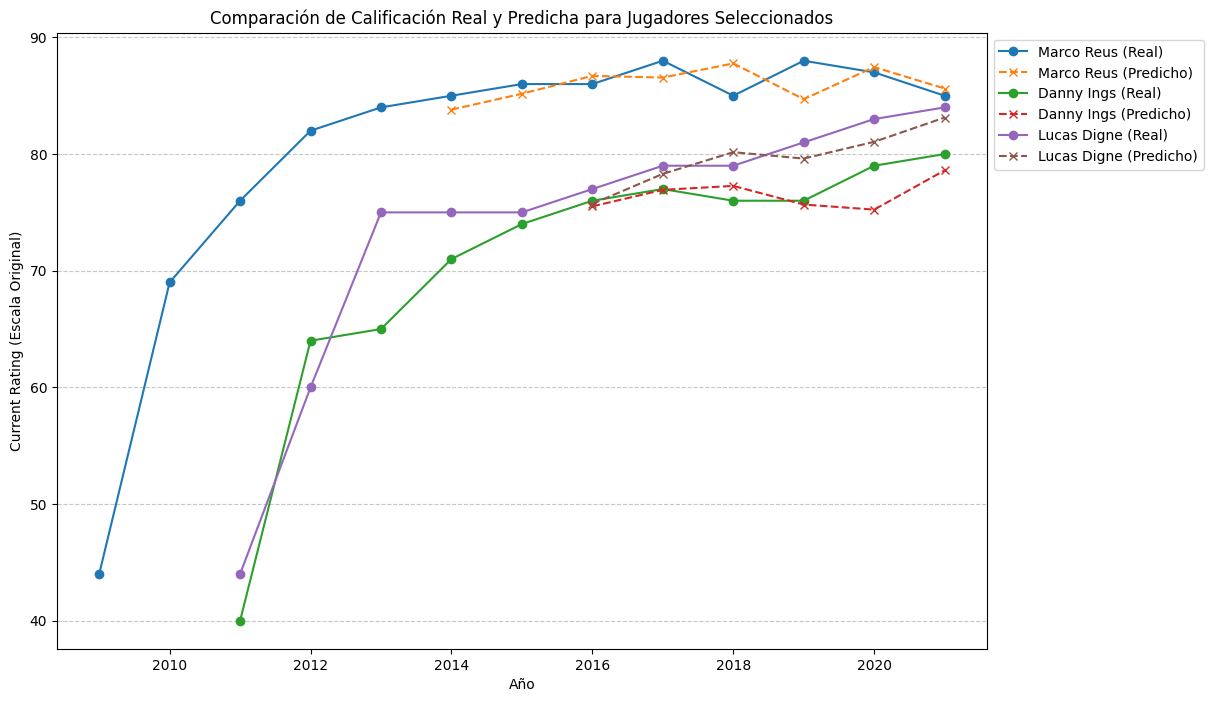

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Definir parámetros de secuencia
sequence_length = 5

# Jugadores seleccionados con mayor progreso
top_players = top_progressors.nlargest(3).index.tolist()

selected_players = top_players

# Crear gráfica
plt.figure(figsize=(12, 8))
for player_id in selected_players:
    # Filtrar datos del jugador y ordenarlos por año
    player_data = df_selected_corr[df_selected_corr['id'] == player_id].sort_values('year')
    real_ratings = (player_data['current_rating'] * current_rating_scale) + current_rating_mean  # Desnormalizar
    years = player_data['year']
    player_name = df[df['id'] == player_id]['Fullname'].iloc[0]  # Obtener nombre del jugador

    # Graficar valores reales
    plt.plot(years, real_ratings, marker='o', label=f"{player_name} (Real)")

    # Crear secuencias y hacer predicciones
    pred_ratings = []
    for i in range(len(player_data) - sequence_length):
        sequence = player_data.iloc[i:i + sequence_length].drop(['id', 'year', 'Fullname'], axis=1).values
        sequence = sequence.reshape(1, sequence_length, -1).astype(np.float32)

        # Predicción y desnormalización
        predicted_rating = RNN_Ponderado.predict(sequence)[0, 0]
        predicted_rating_original = (predicted_rating * current_rating_scale) + current_rating_mean
        pred_ratings.append(predicted_rating_original)

    # Alinear años de las predicciones
    pred_years = years[sequence_length:]  # Comienza desde donde las predicciones tienen datos válidos
    plt.plot(pred_years, pred_ratings, marker='x', linestyle='--', label=f"{player_name} (Predicho)")

# Personalización del gráfico
plt.xlabel("Año")
plt.ylabel("Current Rating (Escala Original)")
plt.title("Comparación de Calificación Real y Predicha para Jugadores Seleccionados")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Se hace lo mismo que antes, pero con ciertos jugadores selecciones, en este caso son Falcao,  Olivier Giroud, Lionel Messi y Karim Benzema.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

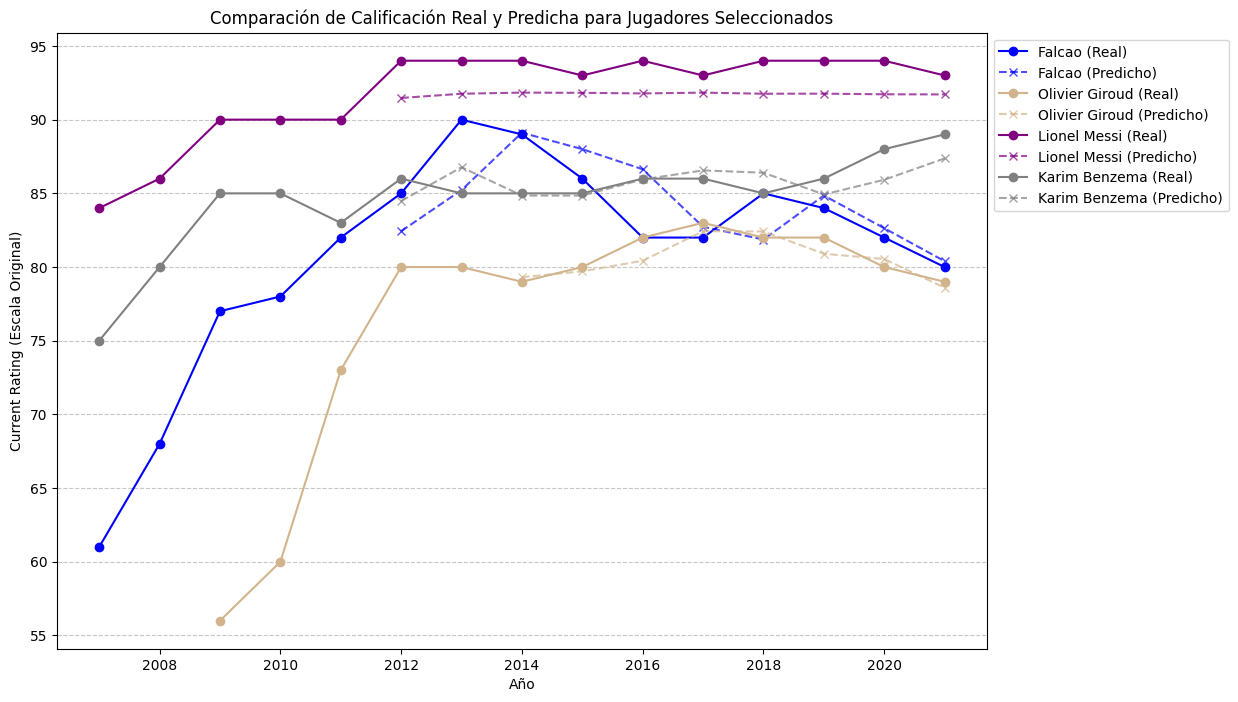

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Cargar el modelo
modelo_cargado = load_model("best_RNN_Ponderado.keras")

# Parámetros de secuencia
sequence_length = 5

# Jugadores seleccionados
selected_players = ["Falcao",  "Olivier Giroud", "Lionel Messi","Karim Benzema"]

# Asignación de colores específicos para cada jugador
player_colors = {
    "Falcao": "blue",
    "Karim Benzema": "grey",
    "Olivier Giroud": "tan",
    "Lionel Messi": "purple"
}

# Crear gráfica
plt.figure(figsize=(12, 8))

for player_name in selected_players:
    # Verificar si el jugador está en el DataFrame
    if player_name in df['Fullname'].values:
        player_id = df[df['Fullname'] == player_name]['id'].iloc[0]
        player_data = df_selected_corr[df_selected_corr['id'] == player_id].sort_values('year')

        # Desnormalizar los valores reales
        real_ratings = (player_data['current_rating'] * current_rating_scale) + current_rating_mean
        years = player_data['year']

        # Color específico para cada jugador
        color = player_colors.get(player_name, "black")  # Color predeterminado si el jugador no está en el diccionario

        # Graficar la trayectoria real con un tono sólido
        plt.plot(years, real_ratings, marker='o', color=color, label=f"{player_name} (Real)")

        # Predicciones alineadas con los años correspondientes
        pred_ratings = []
        pred_years = years[sequence_length:]  # Alinear predicciones con los años correspondientes

        for i in range(len(player_data) - sequence_length):
            # Crear secuencia de entrada
            sequence = player_data.iloc[i:i + sequence_length].drop(['id', 'year', 'Fullname'], axis=1).values
            sequence = sequence.reshape(1, sequence_length, -1).astype(np.float32)

            # Realizar la predicción y desnormalizar
            predicted_rating = modelo_cargado.predict(sequence)[0, 0]
            predicted_rating_original = (predicted_rating * current_rating_scale) + current_rating_mean
            pred_ratings.append(predicted_rating_original)

        # Graficar las predicciones con un tono claro
        plt.plot(pred_years, pred_ratings, marker='x', linestyle='--', color=color, alpha=0.7, label=f"{player_name} (Predicho)")
    else:
        print(f"Advertencia: {player_name} no se encontró en el DataFrame.")

# Personalización del gráfico
plt.xlabel("Año")
plt.ylabel("Current Rating (Escala Original)")
plt.title("Comparación de Calificación Real y Predicha para Jugadores Seleccionados")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()





Ahora se visualizan las predicciones futuras de Mason Mount, Marcus Rashford, Moise Keany Falcao.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

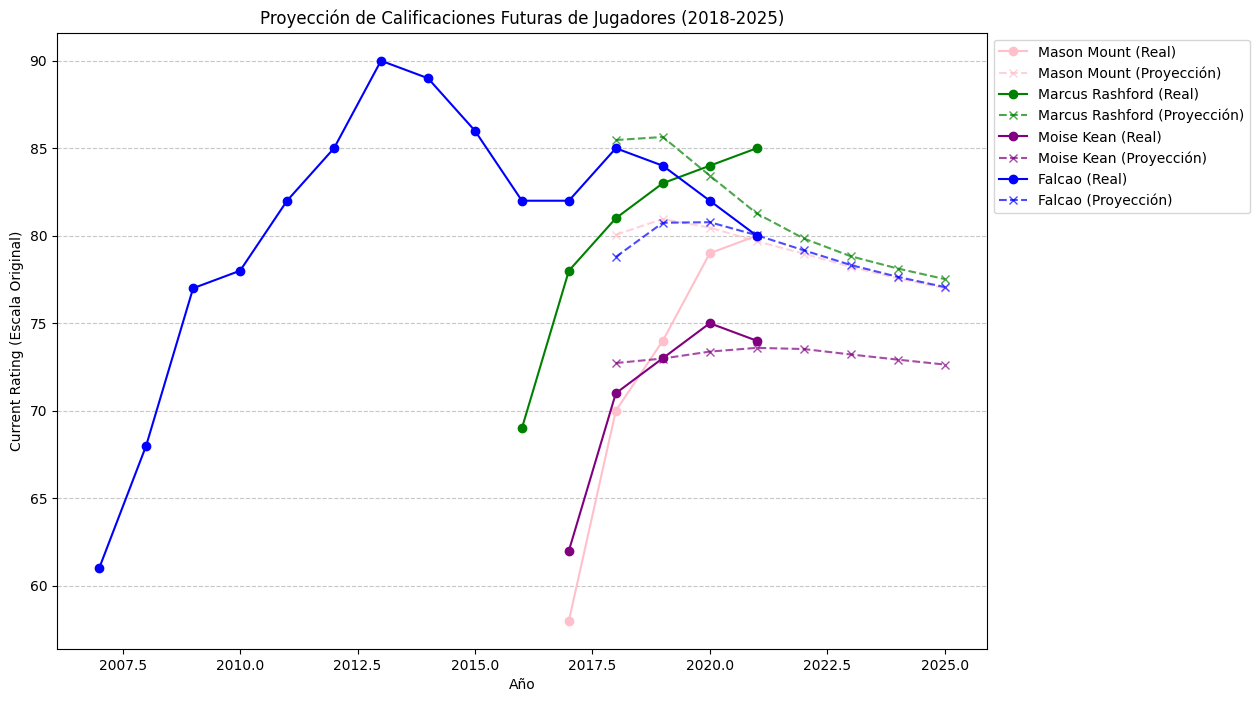

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Cargar el modelo desde el archivo proporcionado
modelo_cargado = load_model("best_RNN_Ponderado.keras")

# Parámetros de secuencia
sequence_length = 5

# Jugadores seleccionados
selected_players = ["Mason Mount", "Marcus Rashford", "Moise Kean", "Falcao"]

# Crear años de predicción que incluyen desde 2018 hasta 2025
future_years = list(range(2018, 2026))

# Asignación de colores específicos para cada jugador
player_colors = {
    "Mason Mount": "pink",
    "Marcus Rashford": "green",
    "Moise Kean": "purple",
    "Falcao": "blue"
}

# Crear gráfica
plt.figure(figsize=(12, 8))

for player_name in selected_players:
    # Verificar si el jugador está en el DataFrame
    if player_name in df['Fullname'].values:
        player_id = df[df['Fullname'] == player_name]['id'].iloc[0]
        player_data = df_selected_corr[df_selected_corr['id'] == player_id].sort_values('year')

        # Desnormalizar los valores reales
        real_ratings = (player_data['current_rating'] * current_rating_scale) + current_rating_mean
        years = player_data['year']

        # Color específico para cada jugador
        color = player_colors.get(player_name, "black")  # Color predeterminado si el jugador no está en el diccionario

        # Graficar la trayectoria real con un tono sólido
        plt.plot(years, real_ratings, marker='o', color=color, label=f"{player_name} (Real)")

        # Usar todas las secuencias reales para realizar predicciones
        last_sequence_data = player_data.iloc[-sequence_length:][numeric_columns].values

        # Verificar si la secuencia tiene la longitud correcta
        if last_sequence_data.shape[0] == sequence_length and last_sequence_data.shape[1] == len(numeric_columns):
            last_sequence = last_sequence_data.reshape(1, sequence_length, -1).astype(np.float32)

            # Predicciones para los años futuros
            future_ratings = []
            for year in future_years:
                # Realizar predicción y desnormalizar
                predicted_rating = modelo_cargado.predict(last_sequence)[0, 0]
                predicted_rating_original = (predicted_rating * current_rating_scale) + current_rating_mean
                future_ratings.append(predicted_rating_original)

                # Asegurar que la nueva predicción tenga la misma forma que la secuencia
                predicted_value_reshaped = np.full((1, 1, last_sequence.shape[2]), predicted_rating)

                # Actualizar la secuencia con la nueva predicción
                last_sequence = np.append(last_sequence[:, 1:, :], predicted_value_reshaped, axis=1)

            # Graficar las predicciones alineadas con los años futuros
            plt.plot(future_years, future_ratings, marker='x', linestyle='--', color=color, alpha=0.7, label=f"{player_name} (Proyección)")
        else:
            print(f"Advertencia: La secuencia para {player_name} tiene forma {last_sequence_data.shape} y no coincide con la esperada.")
    else:
        print(f"Advertencia: {player_name} no se encontró en el DataFrame.")

# Personalización del gráfico
plt.xlabel("Año")
plt.ylabel("Current Rating (Escala Original)")
plt.title("Proyección de Calificaciones Futuras de Jugadores (2018-2025)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Y por último se visualiza el error absoluto medio (MAE) por posición.

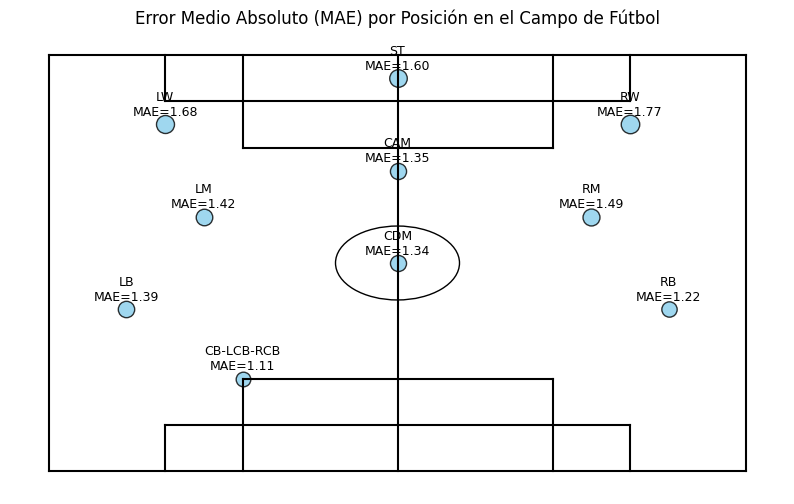

In [ ]:
import matplotlib.pyplot as plt

# Posiciones y errores, excluyendo porteros
positions_updated = {
    'CB-LCB-RCB': (30, 25),
    'LB': (15, 40),
    'RB': (85, 40),
    'CDM': (50, 50),
    'LM': (25, 60),
    'RM': (75, 60),
    'CAM': (50, 70),
    'LW': (20, 80),
    'RW': (80, 80),
    'ST': (50, 90)
}

mae_position_updated = {
    'CB-LCB-RCB': 1.11,
    'LB': 1.39,
    'RB': 1.22,
    'CDM': 1.34,
    'LM': 1.42,
    'RM': 1.49,
    'CAM': 1.35,
    'LW': 1.68,
    'RW': 1.77,
    'ST': 1.60
}

# Crear campo de fútbol
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlim(0, 100)
plt.ylim(0, 100)

# Líneas del campo
plt.plot([5, 5], [5, 95], color="black")
plt.plot([95, 95], [5, 95], color="black")
plt.plot([5, 95], [5, 5], color="black")
plt.plot([5, 95], [95, 95], color="black")
plt.plot([20, 20], [5, 15], color="black")
plt.plot([80, 80], [5, 15], color="black")
plt.plot([20, 80], [15, 15], color="black")
plt.plot([30, 30], [5, 25], color="black")
plt.plot([70, 70], [5, 25], color="black")
plt.plot([30, 70], [25, 25], color="black")
plt.plot([20, 20], [95, 85], color="black")
plt.plot([80, 80], [95, 85], color="black")
plt.plot([20, 80], [85, 85], color="black")
plt.plot([30, 30], [95, 75], color="black")
plt.plot([70, 70], [95, 75], color="black")
plt.plot([30, 70], [75, 75], color="black")
plt.plot([50, 50], [5, 95], color="black")
circle = plt.Circle((50, 50), 8, color="black", fill=False)
ax.add_patch(circle)

# Dibujar errores por posición de forma estética
for pos, coord in positions_updated.items():
    error = mae_position_updated.get(pos, 1.0)
    plt.scatter(*coord, s=error * 100, color="skyblue", edgecolor="black", alpha=0.8)
    plt.text(coord[0], coord[1] + 2, f"{pos}\nMAE={error:.2f}", ha='center', fontsize=9)

# Ajustes finales
plt.title("Error Medio Absoluto (MAE) por Posición en el Campo de Fútbol")
plt.axis("off")
plt.show()

